In [1]:
%%capture
%pylab inline
import xarray as xr
import glob

def loadRastaflt(szi):
#     matlabpath='/data/mcfarq/a/szhu28/research/HIWC/10_150901Wholeflight/src/analysis/example/data/'
    rastafn=glob.glob(datapath+'*_F'+str(szi)+'_*.nc')
    return xr.open_dataset(rastafn[0])

In [2]:
import scipy.io as sio    # For .mat version before 7.3
import h5py    # For .mat version after 7.3
import pandas as pd
matlabpath='/data/mcfarq/a/szhu28/research/HIWC/10_150901Wholeflight/src/analysis/example/data/'
datapath='/data/mcfarq/a/szhu28/research/HIWC/data/fulldataDarwin/RASTA/data/'
filenames=np.array(['processed.mat','rawFIT.mat','rawPSD.mat','rawVAR.mat'])
'''
for szi in range(4):
    tmpfn=matlabpath+filenames[szi]
    try:
        raw=h5py.File(tmpfn,'r')
#         print('hdf '+str(szi))
        raw.close()
    except:
        raw=sio.loadmat(tmpfn)
#         raw=sio.whosmat(tmpfn)
#         varnames=raw.items()
'''
raw=sio.loadmat(matlabpath+filenames[3])
proc=sio.loadmat(matlabpath+filenames[0])
proc['indpsdforward']-=1                     ############ PYTHON VS MATLAB
proc['indpsdback']-=1

### 5 seconds running mean of iwc
tmpiwc=pd.DataFrame(raw['TWCIKPZRgm3'].ravel())
iwc_mean=tmpiwc.rolling(window=5,center=True,min_periods=3).mean().as_matrix()

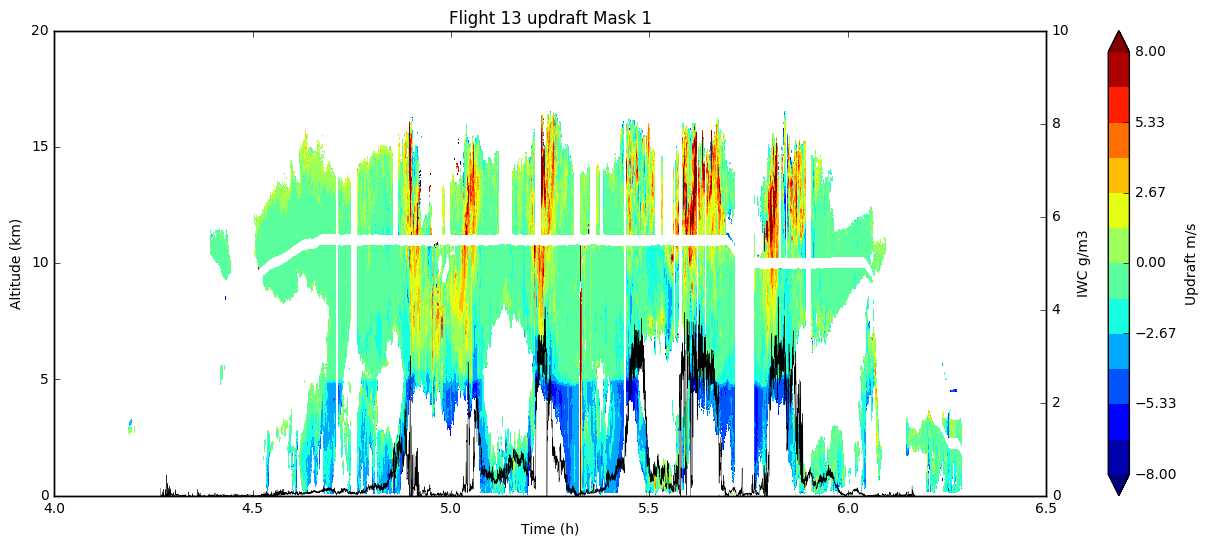

In [3]:
ds = loadRastaflt(13)
tmp=ds['Vz']
# tmp=tmp.where((ds.Mask_Vz==1) | (ds.Mask_Vz==3))
tmp=tmp.where((ds.Mask_Vz==1))
# thresh=14
# tmp=tmp.where((tmp<thresh) & (tmp>-thresh))
tmp=tmp.transpose()
fig=plt.figure(figsize=[16,6])    ########### comment me
plt.contourf(np.tile(ds.time.values,(tmp.values.shape[0],1)),ds.height_2D.transpose(),
             tmp,np.linspace(-8,8,13),extend='both')
ax=plt.gca()
hcb=plt.colorbar()
hcb.set_label('Updraft m/s')
plt.ylim(0,20)
plt.xlabel('Time (h)')
plt.ylabel('Altitude (km)')
plt.title('Flight 13 updraft Mask 1')
ax2=ax.twinx()
indflt=(raw['flightnum']==13)
iwc=raw['TWCIKPZRgm3'][indflt]
time=raw['Time'][indflt]
ax2.plot(time/3600.,iwc,'k',linewidth=0.3)
ax2.set_ylim(0,10)
_=ax2.set_ylabel('IWC g/m3')

### Updraft in flight 13 from RASTA.
In RASTA there're two types of masks. One called Mask in the above figures is for the Vz component, where 1 stands for good confidence, 2 for should not be used, 3 for could be used but carefully. The second system of masks is denoted as Phs Mk in the following figures indicates the Attenuation and Phase flag, where meaning of each flag is written in the figures. All plots are overlaid with IWC curve to indicate the time when in cloud or not.

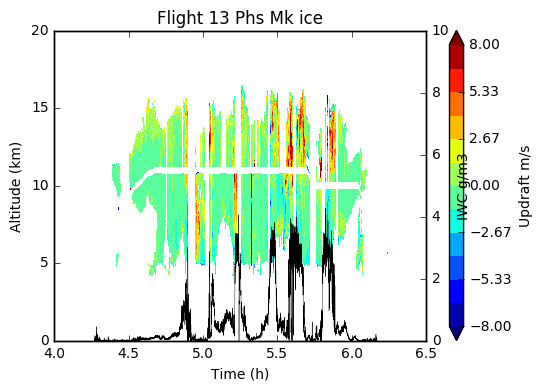

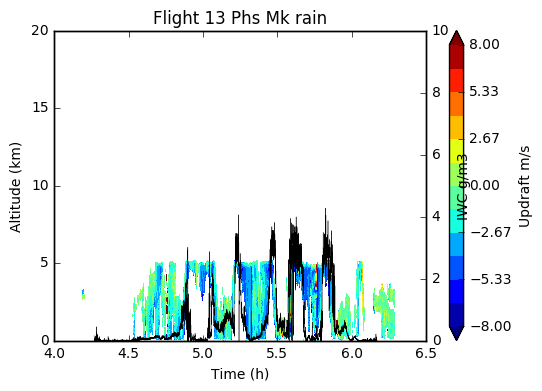

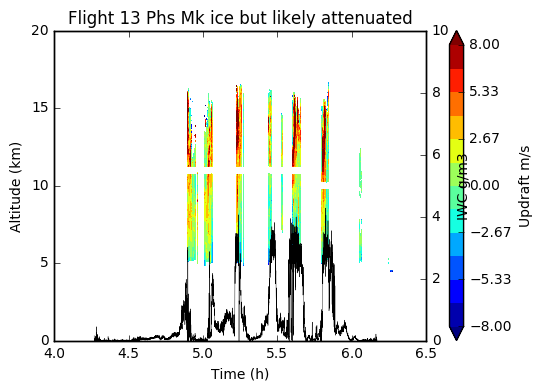

/data/keeling/a/szhu28/usr/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


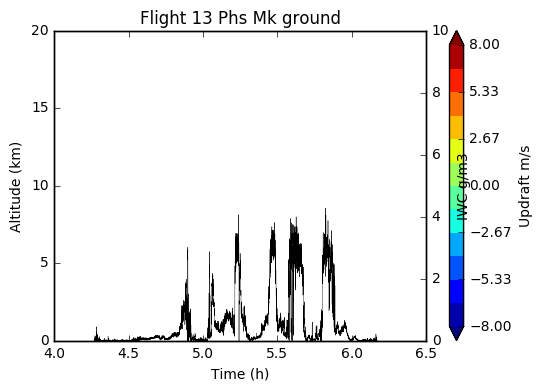

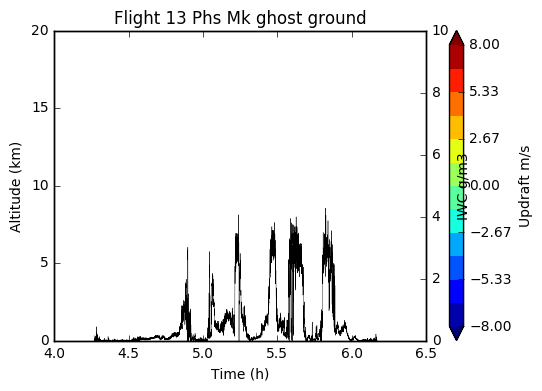

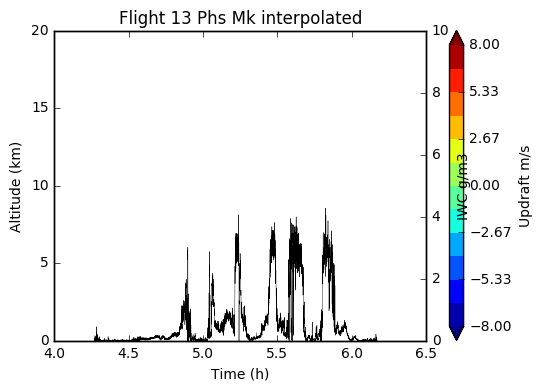

In [4]:
attmk=np.array(['no cloud','ice','rain','ice but likely attenuated','ground','ghost ground','interpolated'])
szi=13
for j in range(6):
    szj=j+1
    ds = loadRastaflt(szi)
    tmp=ds.Vz.where((ds.Mask_Vz==1) | (ds.Mask_Vz==3))
    tmp=tmp.where(ds.attenuation_phase_flag==szj)
    # tmp=tmp.where((ds.Mask_Vz==1))
    # thresh=14
    # tmp=tmp.where((tmp<thresh) & (tmp>-thresh))
    tmp=tmp.transpose()
    #fig=plt.figure(figsize=[16,6])    ########### comment me
    plt.contourf(np.tile(ds.time.values,(tmp.values.shape[0],1)),ds.height_2D.transpose(),
                 tmp,np.linspace(-8,8,13),extend='both')
    ax=plt.gca()
    hcb=plt.colorbar()
    hcb.set_label('Updraft m/s')
    plt.ylim(0,20)
    plt.xlabel('Time (h)')
    plt.ylabel('Altitude (km)')
    plt.title('Flight '+str(szi)+' Phs Mk '+str(attmk[szj]))
    ax2=ax.twinx()
    indflt=(raw['flightnum']==szi)
    iwc=raw['TWCIKPZRgm3'][indflt]
    time=raw['Time'][indflt]
    ax2.plot(time/3600.,iwc,'k',linewidth=0.3)
    ax2.set_ylim(0,10)
    ax2.set_ylabel('IWC g/m3')
    plt.show()

Gate    [245, 246, 247, 248, 249, 250, 251, 252, 253, 254]
Points [4667   36   35    0    0    0    0    2    2 4445]


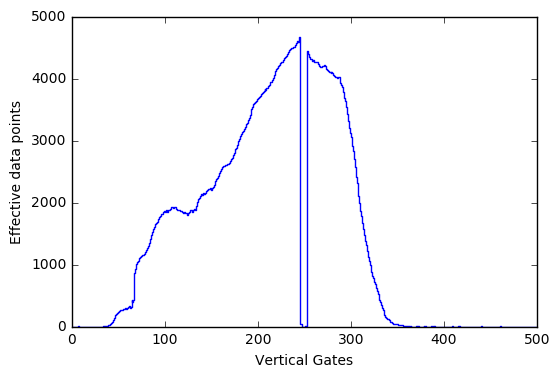

In [5]:
tmp=(~np.isnan(ds['Vz'].values)).sum(axis=0)
plt.step(range(len(tmp)),tmp)
plt.xlabel('Vertical Gates')
plt.ylabel('Effective data points')
print('Gate    '+str(range(245,255)))
print('Points '+str(tmp[245:255]))

### Vz near flight track
Vz is the vertical component of the retrieved 3-D winds from RASTA. There are 500 vertical gates in all and the aircraft is between gate 249 and 250. The figure above indicates there are very few efficient data 3 gates within the aircraft.

The following figure shows the gates altitude with respect to the gate 249. It's still not clear why the relative range is not constant throughout time. It's now clear that the roll angle is causing the actual altitude change of the gates.

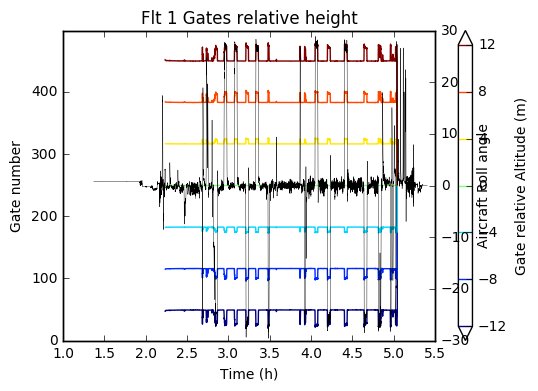

In [6]:
for i in range(1):
    szi=i+1
    try:
        ds=loadRastaflt(szi)
    except:
        continue;
    tmp=ds['height_2D']-np.mean( ds['height_2D'][:,np.array([249,250])],axis=1)
    tmp=tmp.transpose()
    plt.contour(np.tile(ds.time.values,(tmp.values.shape[0],1)),
                np.tile(np.linspace(0,499,500)[:,np.newaxis],(1,tmp.values.shape[1])) ,tmp,
                np.linspace(-12,12,7),extend='both')
    plt.ylabel('Vertical Gates')
    plt.xlabel('Time (seconds)')
    plt.title('Flt '+str(szi)+' Gates relative height')

    ax=plt.gca()
    hcb=plt.colorbar()
    hcb.set_label('Gate relative Altitude (m)')
    plt.xlabel('Time (h)')
    plt.ylabel('Gate number')
    ax2=ax.twinx()
    indflt=(raw['flightnum']==szi)
    iwc=raw['roll'][indflt]
    time=raw['Time'][indflt]
    ax2.plot(time/3600.,iwc,'k',linewidth=0.3)
    #ax2.set_ylim(0,10)
    ax2.set_ylabel('Aircraft Roll angle')
    plt.show()

In [7]:
print('Distance between gates is '+str(np.average(np.diff(ds.range)))+' km')

Distance between gates is 0.06 km


The RASTA dataset actually contain part of the latest V5 SAFFIRE data and it reminds me that the SAFFIRE data I'm currently using (V3) is outdated. The below linear regressions shows the SAFFIRE updraft comparison between V5 and V3 in each flight. Most of them OK, some flight has large deviation.

Flight 1
	Rsquare 0.665287768912
		Slope 0.629330368337
			Intercept -0.109340798266
Flight 2
	Rsquare 0.943091898392
		Slope 0.916037904828
			Intercept 0.0878336075817
Flight 3
	Rsquare 0.749297831797
		Slope 0.73795700209
			Intercept -0.19500508223
Flight 4
	Rsquare 0.763544592243
		Slope 0.754191642829
			Intercept -0.0194403315007
Flight 6
	Rsquare 0.921043406861
		Slope 0.922959206127
			Intercept 0.0288470242599
Flight 7
	Rsquare 0.421170457016
		Slope 0.428801552961
			Intercept 0.004779094912
Flight 8
	Rsquare 0.964276436554
		Slope 0.95436160873
			Intercept 0.208536995536
Flight 9
	Rsquare 0.462126202063
		Slope 0.5168740355
			Intercept -0.05345809559
Flight 10
	Rsquare 0.938236698598
		Slope 0.912488188982
			Intercept 0.147214690337
Flight 11
	Rsquare 0.405849624119
		Slope 0.551979569749
			Intercept -0.243388429539
Flight 12
	Rsquare 0.954375714486
		Slope 0.943046962521
			Intercept -0.00225336751511
Flight 13
	Rsquare 0.837665117814
		Slope 0.836126486166
			Intercep

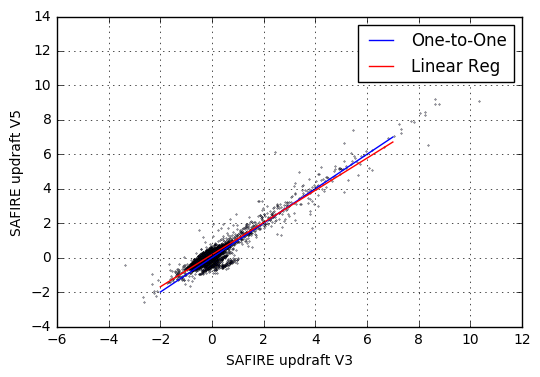

In [8]:
for j in range(23):
    try:
        szj=j+1
        ds = loadRastaflt(szj)
        indflt=(raw['flightnum']==szj)
        wwind=raw['wwind'][indflt]
        time=raw['Time'][indflt]

        timera=ds.time.values*3600
        timerauni=np.unique(timera.round())
        timerauni.shape

        common=numpy.intersect1d(time, timerauni)
        ind1=np.array([ np.sum(a == common) for a in time ]).astype(bool)
        ind2=np.array([ np.sum(a == common) for a in timerauni ]).astype(bool)
        w1=wwind[ind1]
        w2=ds.w_wind.values[ind2]

        from scipy import stats
        plt.scatter(w1,w2,s=.1)
        o2o=np.array(plt.gca().get_ylim())*0.5
        plt.plot(o2o,o2o,'b')
        plt.grid(b=True)
        mask = ~np.isnan(w1) & ~np.isnan(w2)
        slope, intercept, r_value, p_value, std_err = stats.linregress(w1[mask],w2[mask] )
        plt.plot(o2o,o2o*slope+intercept,'r')
        plt.xlabel('SAFIRE updraft V3')
        plt.ylabel('SAFIRE updraft V5')
        print('Flight '+str(szj))
        print('\tRsquare '+str(r_value**2))
        print('\t\tSlope '+str(slope))
        print('\t\t\tIntercept '+str(intercept))
        plt.legend(['One-to-One','Linear Reg']);
        if szj!=23:
            plt.close()
    except:
        pass

Rsquare 0.376722655401
Slope 0.736773849808
Intercept -0.788723648127


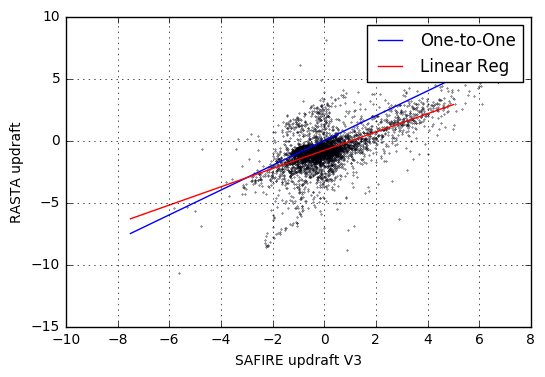

In [9]:
ds = loadRastaflt(13)
indflt=(raw['flightnum']==13)
wwind=raw['wwind'][indflt]
time=raw['Time'][indflt]

timera=ds.time.values*3600
timerauni=np.unique(timera.round())
timerauni.shape

common=numpy.intersect1d(time, timerauni)
ind1=np.array([ np.sum(a == common) for a in time ]).astype(bool)
ind2=np.array([ np.sum(a == common) for a in timerauni ]).astype(bool)
w1=wwind[ind1]
w2=np.mean( ds.Vz.values[ind2][:,np.array([245,254])], axis=1)

from scipy import stats
plt.scatter(w1,w2,s=.1)
o2o=np.array(plt.gca().get_ylim())*0.5
plt.plot(o2o,o2o,'b')
plt.grid(b=True)
mask = ~np.isnan(w1) & ~np.isnan(w2)
slope, intercept, r_value, p_value, std_err = stats.linregress(w1[mask],w2[mask] )
plt.plot(o2o,o2o*slope+intercept,'r')
plt.xlabel('SAFIRE updraft V3')
plt.ylabel('RASTA updraft')
print('Rsquare '+str(r_value**2))
print('Slope '+str(slope))
print('Intercept '+str(intercept))
plt.legend(['One-to-One','Linear Reg']);

The updraft at the aircraft location are derived from RASTA by computing the average of the closest effective gates above and below the aircraft, i.e. gate 245 and 254.

The correlation between updraft from RASTA retrieved and the SAFFIRE (upper figure V3, lower figure V5) is displayed. Both of them show a low correlation coefficient and the RASTA tends to be underestimating strong updrafts.

Rsquare 0.434348894468
Slope 0.849404977411
Intercept -0.900162006002


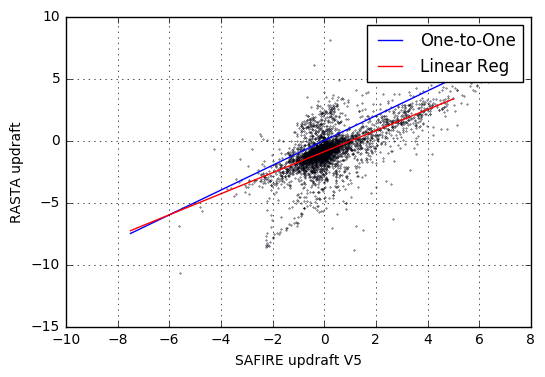

In [10]:
ds = loadRastaflt(13)

w1=ds.w_wind.values
w2=np.mean( ds.Vz.values[:,np.array([245,254])], axis=1)

from scipy import stats
plt.scatter(w1,w2,s=.1)
o2o=np.array(plt.gca().get_ylim())*0.5
plt.plot(o2o,o2o,'b')
plt.grid(b=True)
mask = ~np.isnan(w1) & ~np.isnan(w2)
slope, intercept, r_value, p_value, std_err = stats.linregress(w1[mask],w2[mask] )
plt.plot(o2o,o2o*slope+intercept,'r')
plt.xlabel('SAFIRE updraft V5')
plt.ylabel('RASTA updraft')
print('Rsquare '+str(r_value**2))
print('Slope '+str(slope))
print('Intercept '+str(intercept))
plt.legend(['One-to-One','Linear Reg']);

## IMPORTANT
Below are comparisons of vertical updraft profiles between flight 13 (double mode PSD case) and flight 16 (single mode PSD case). We shall discuss this figure sometime as I don't have much experience in interpreting radar images. But for now some things I could think of are

1. Why could there be vertically inconsistent updraft profile? This might mean the convection initiated from the mid-level rather than from the sea surface.
2. ***Flight 16 has higher updraft below the aircraft,*** which, in the back-tracking sense, indicates the ice particles in the aircraft level are of younger age (since they're lifted fast and do not lay over in the layer). This could partly explain why the PSD tends to be single moded in flight 16 because there's not enough time for aggregation, i.e., formation of a second mode.

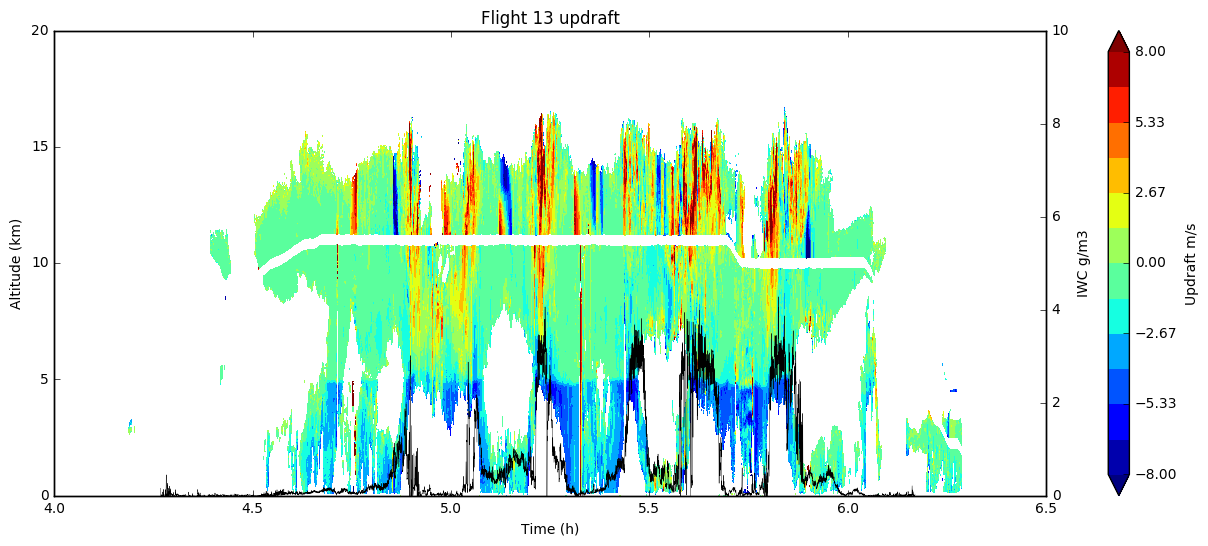

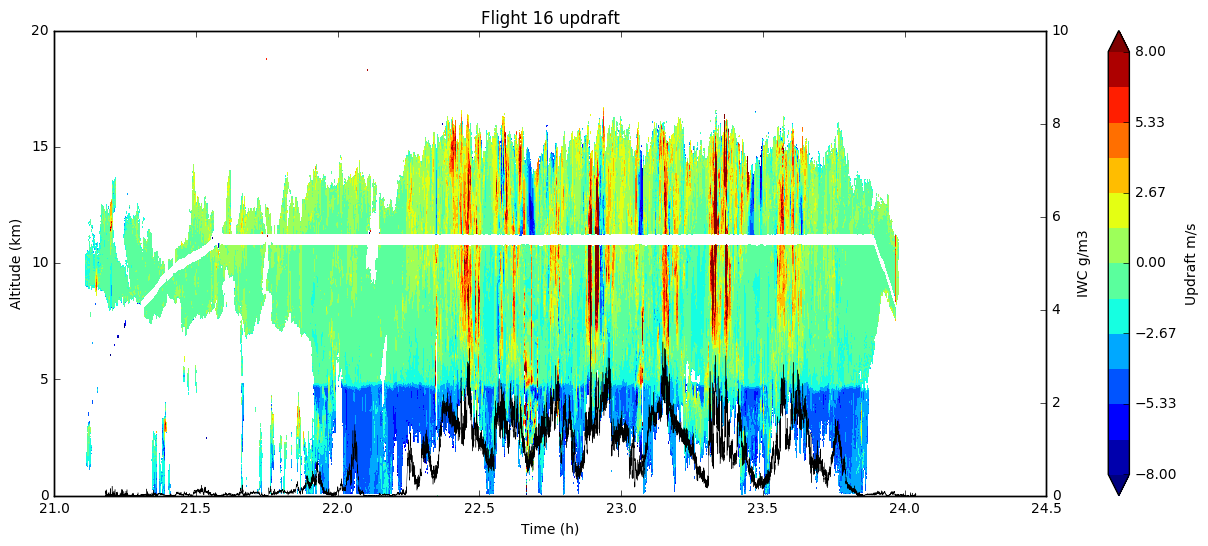

In [11]:
for i in [12,15]:
    try:
        szi=i+1
        fig=figure(figsize=[16,6])
        ds = loadRastaflt(szi)
        tmp=ds.Vz.where((ds.Mask_Vz==1) | (ds.Mask_Vz==3))
        #tmp=tmp.where((ds.attenuation_phase_flag==1) | (ds.attenuation_phase_flag==3))
        # tmp=tmp.where((ds.Mask_Vz==1))
        tmp=tmp.transpose()
        plt.contourf(np.tile(ds.time.values,(tmp.values.shape[0],1)),ds.height_2D.transpose(),
                     tmp,np.linspace(-8,8,13),extend='both')
        ax=plt.gca()
        hcb=plt.colorbar()
        hcb.set_label('Updraft m/s')
        plt.ylim(0,20)
        plt.xlabel('Time (h)')
        plt.ylabel('Altitude (km)')
        plt.title('Flight '+str(szi)+' updraft')
        ax2=ax.twinx()
        indflt=(raw['flightnum']==szi)
        iwc=raw['TWCIKPZRgm3'][indflt]
        time=raw['Time'][indflt]
        ax2.plot(time/3600.,iwc,'k',linewidth=0.3)
        ax2.set_ylim(0,10)
        ax2.set_ylabel('IWC g/m3')
        plt.show()
    except:
        pass

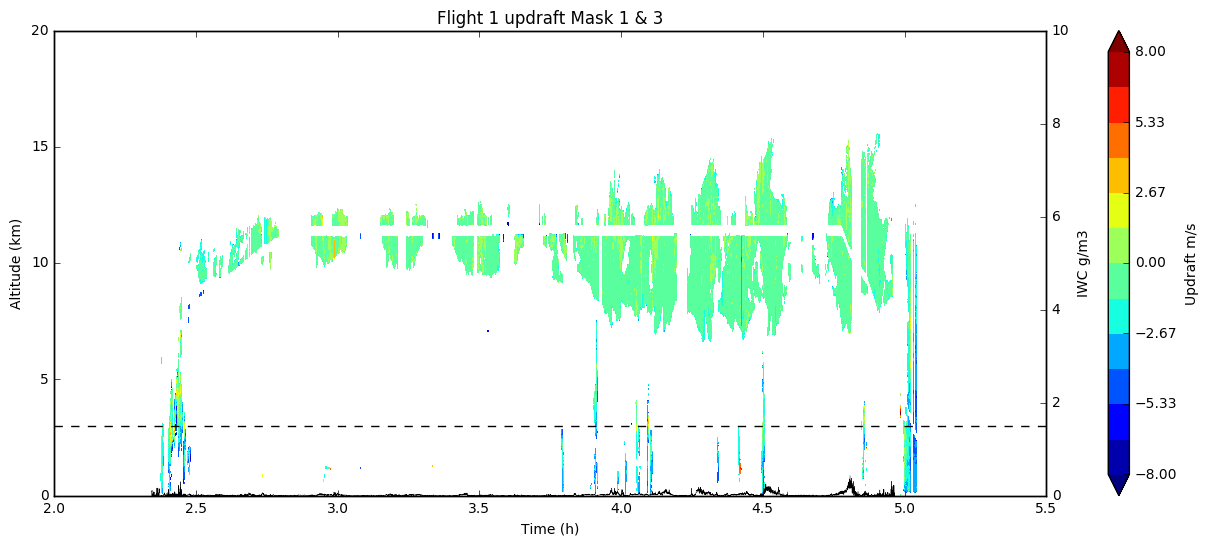

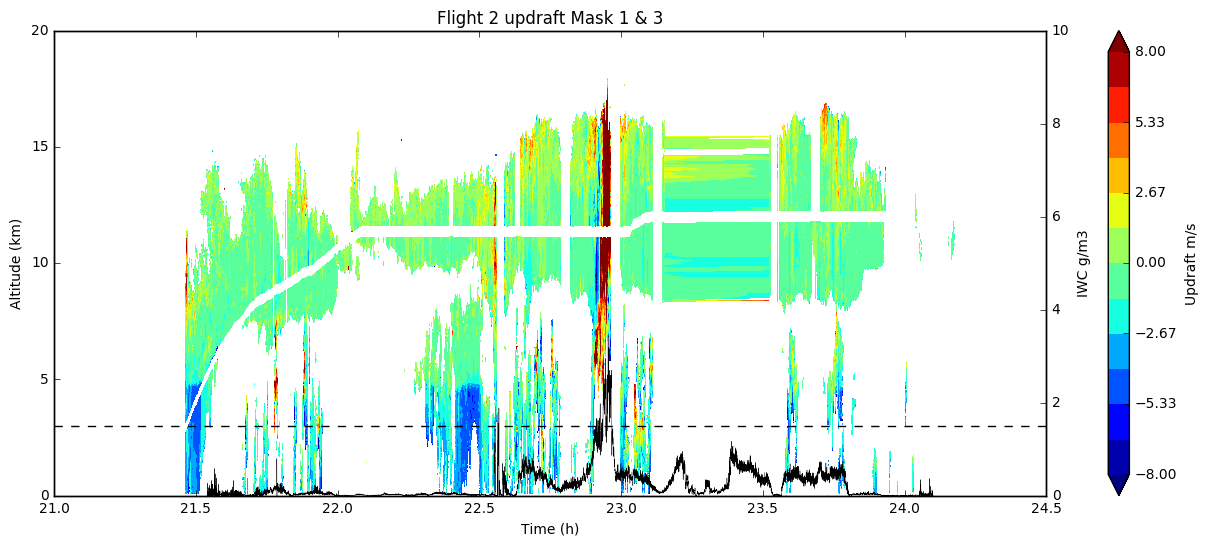

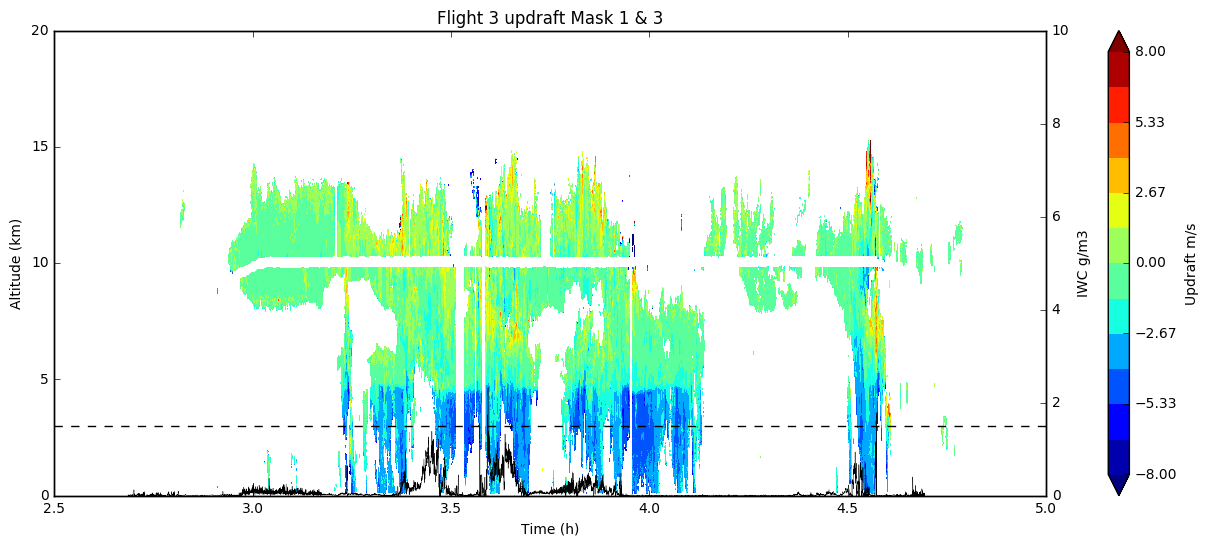

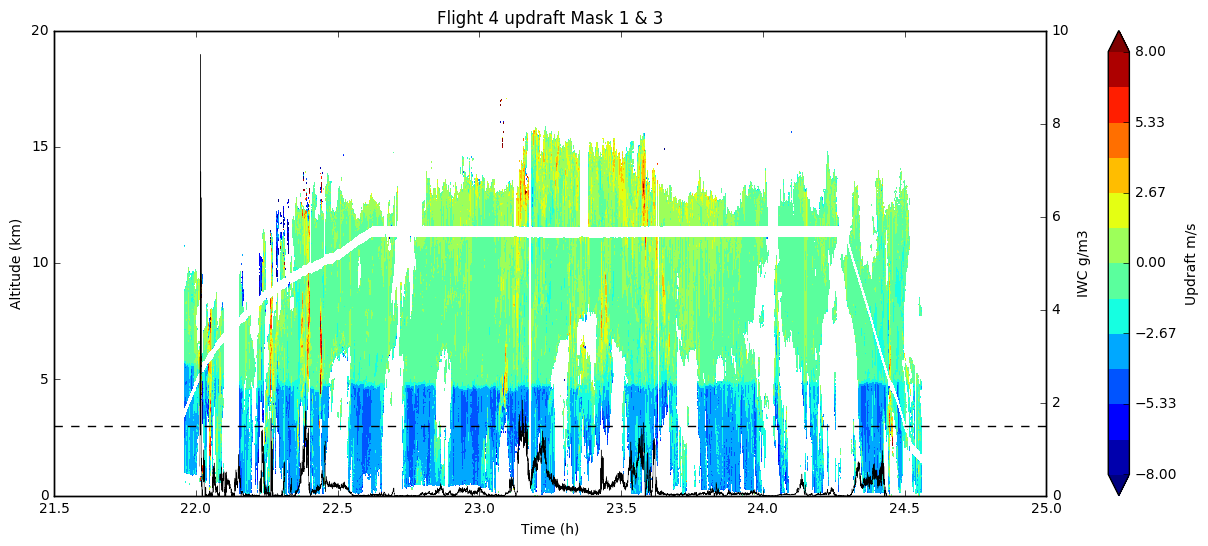

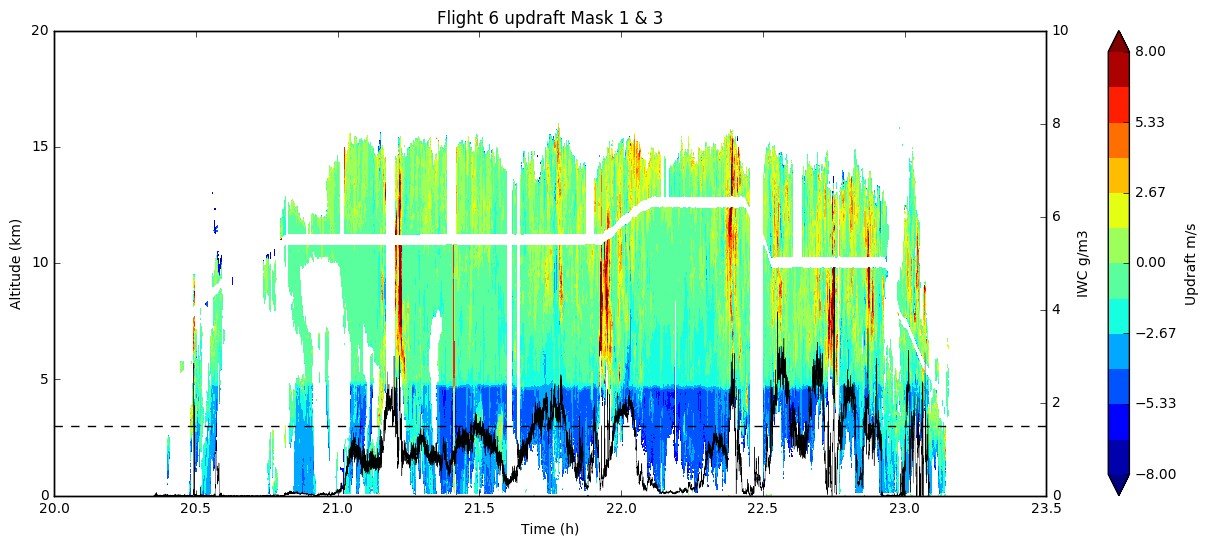

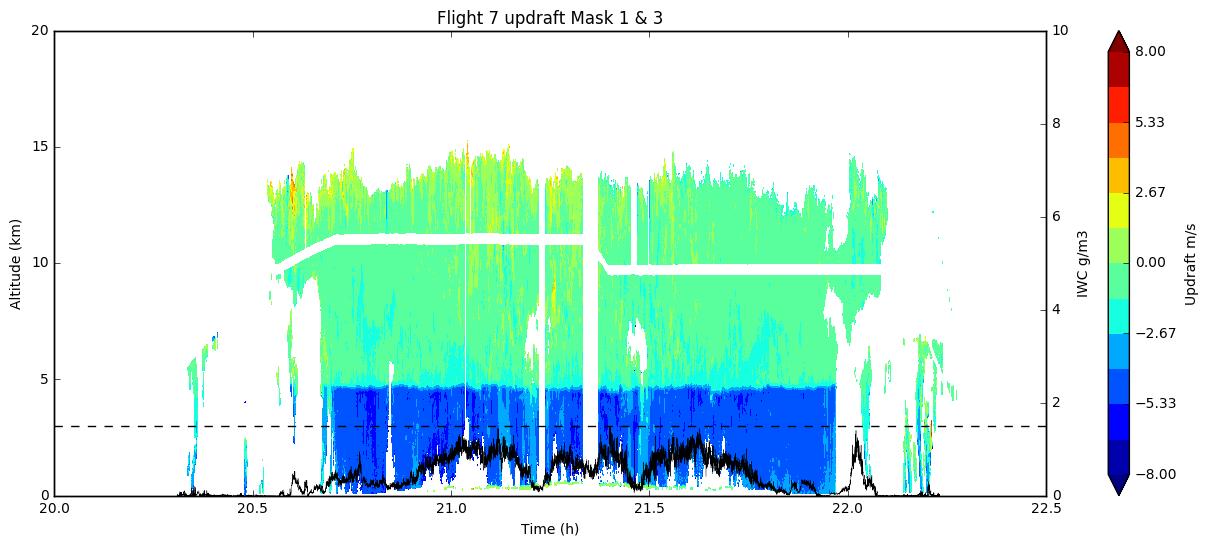

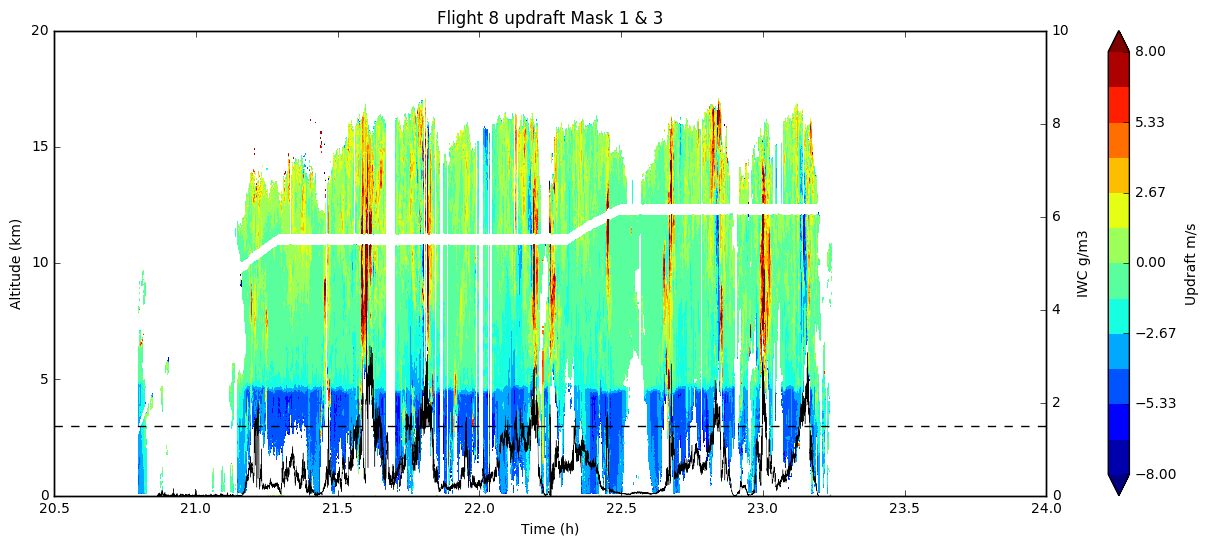

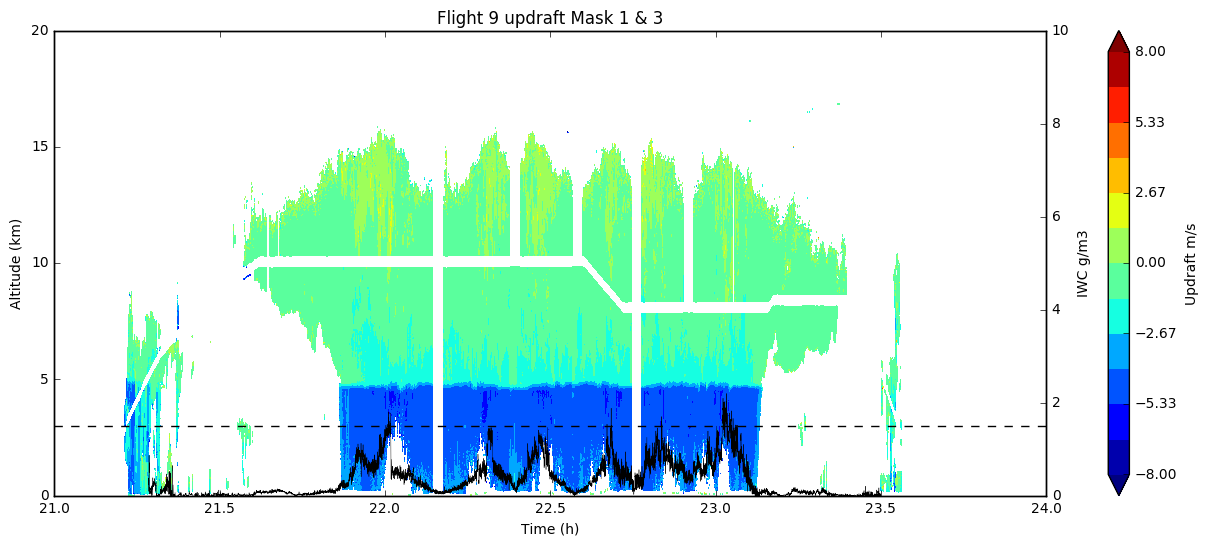

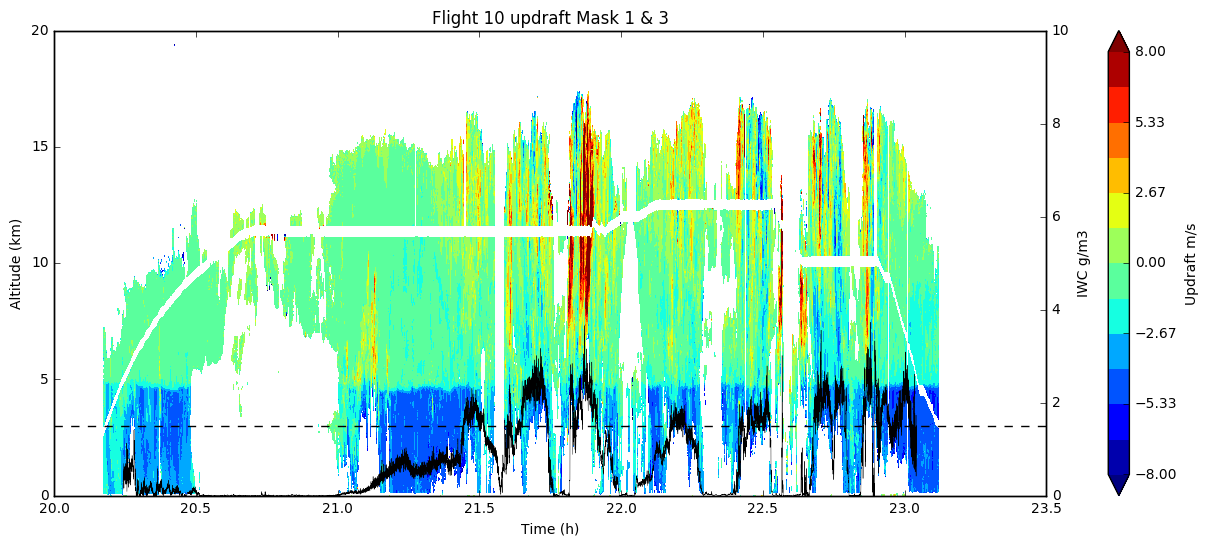

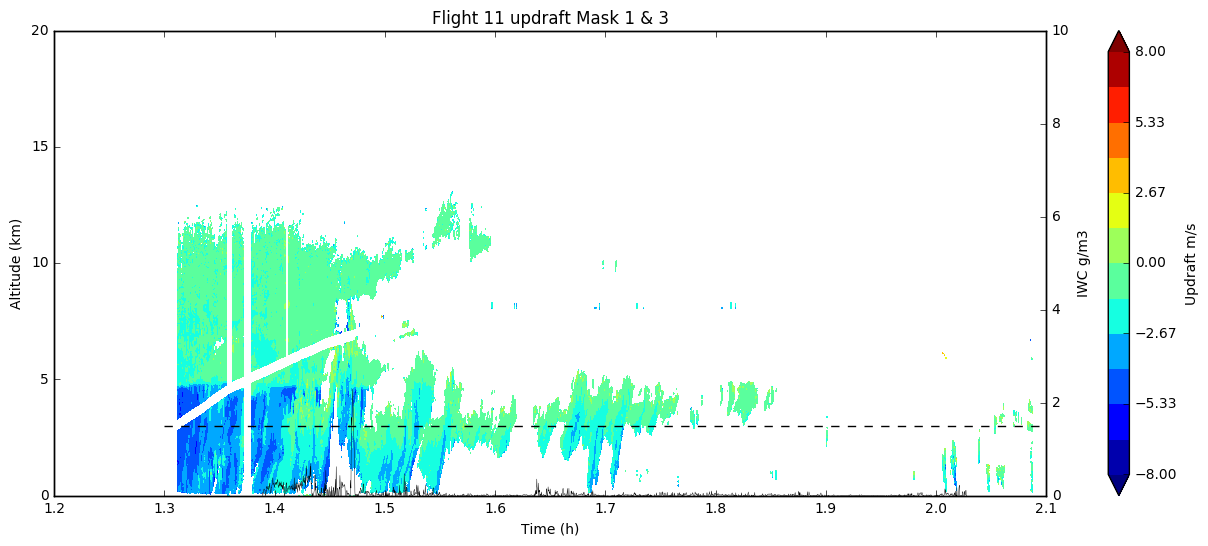

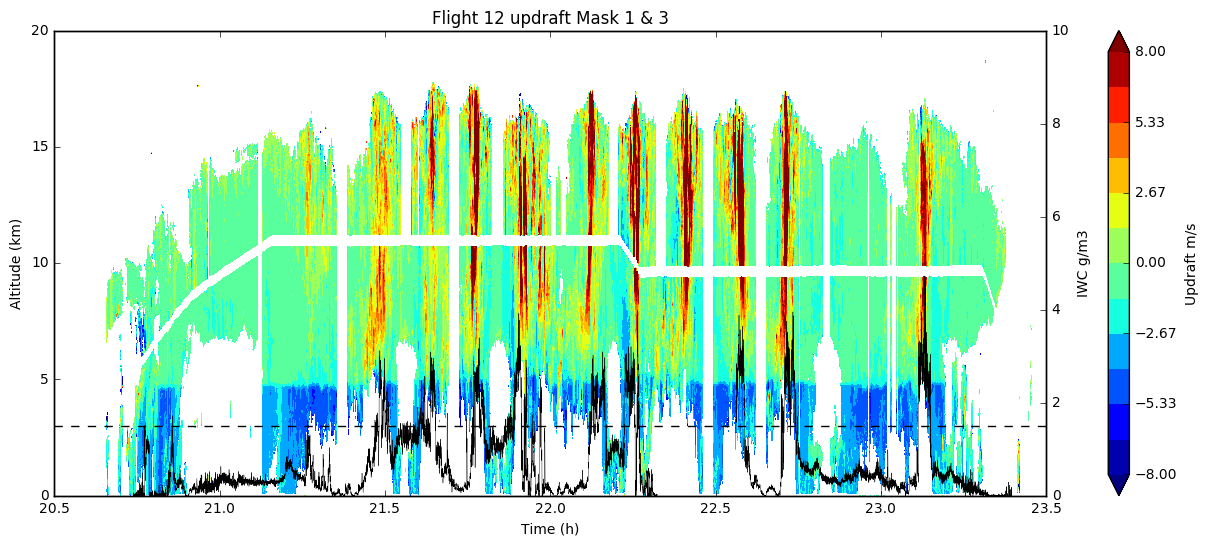

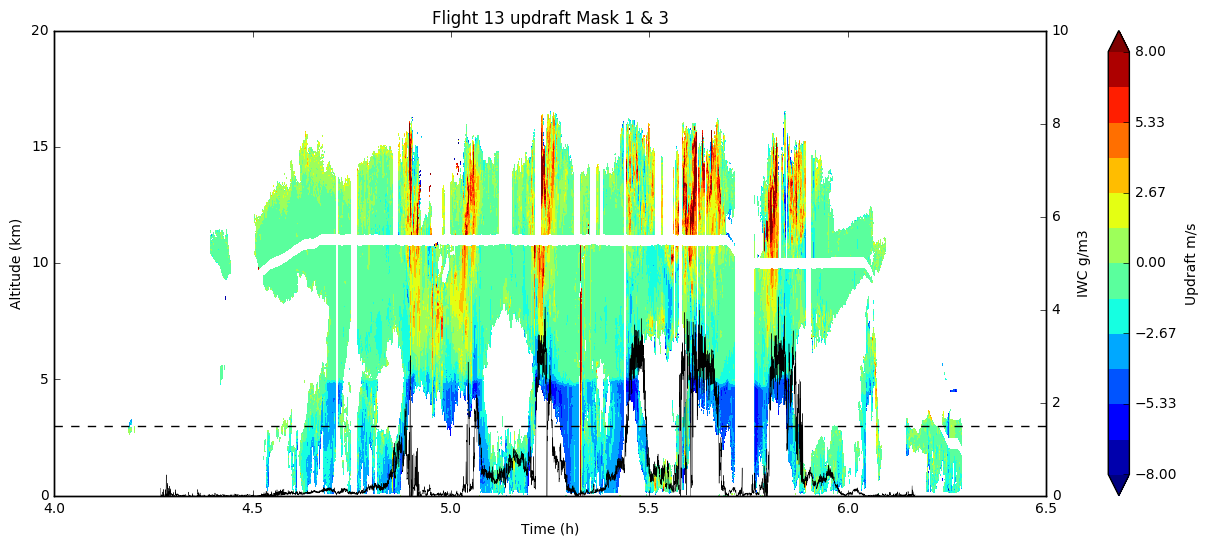

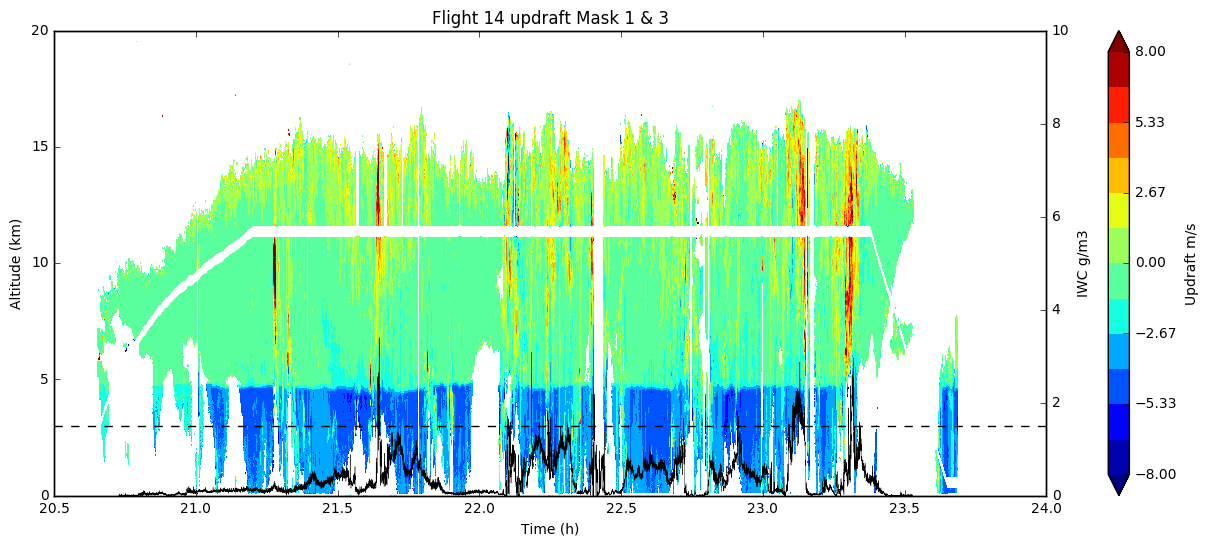

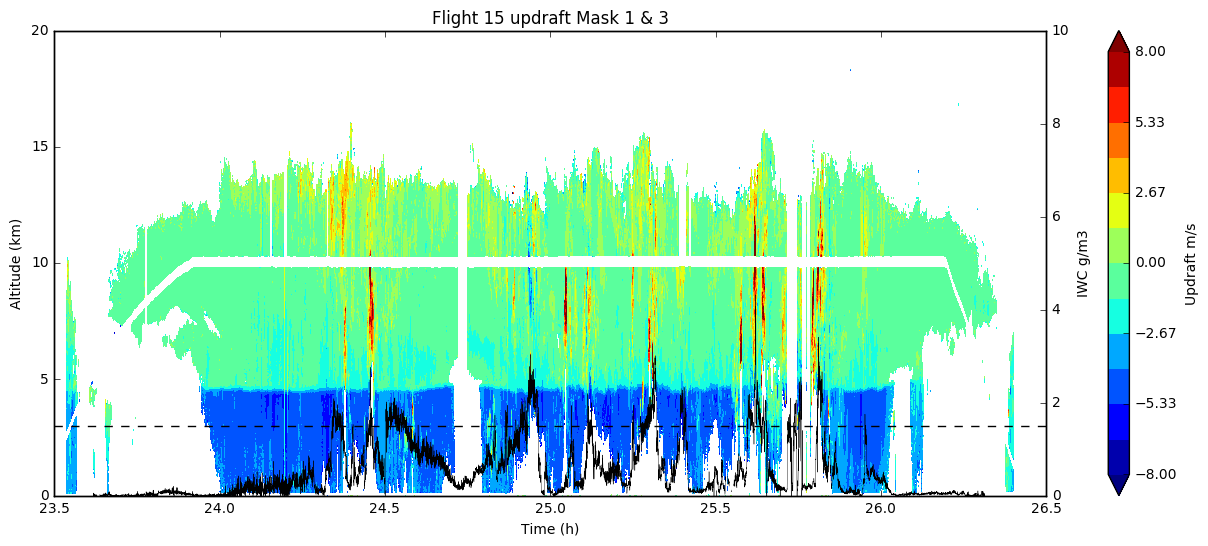

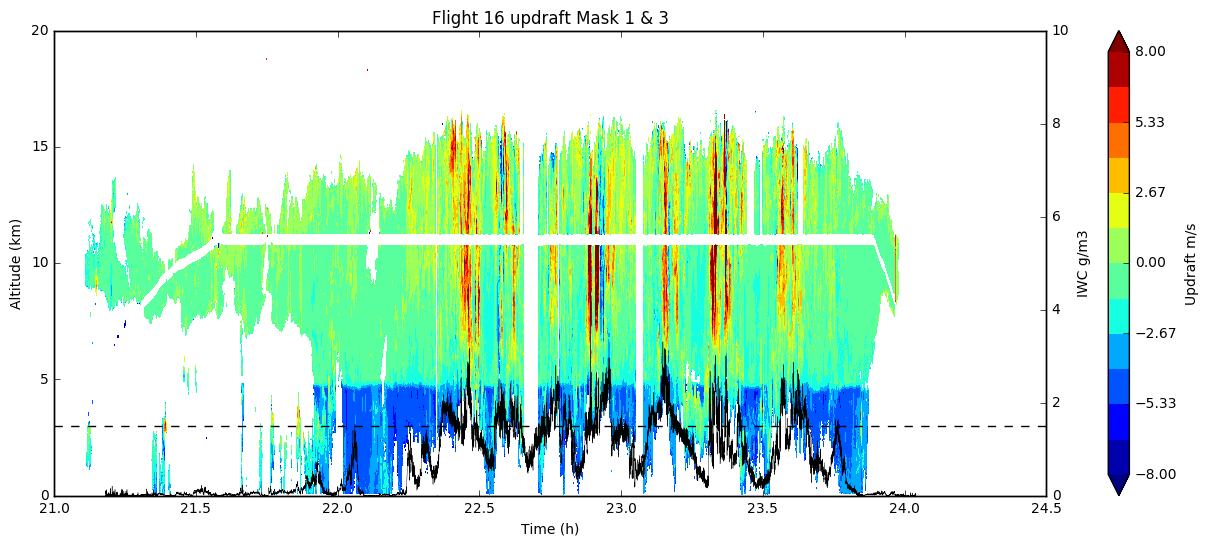

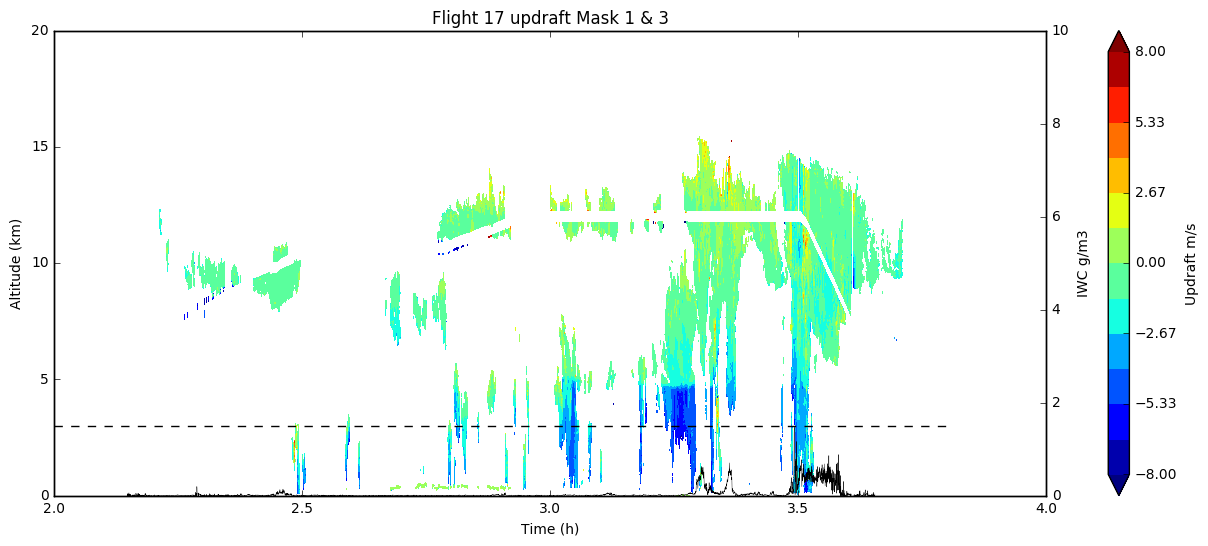

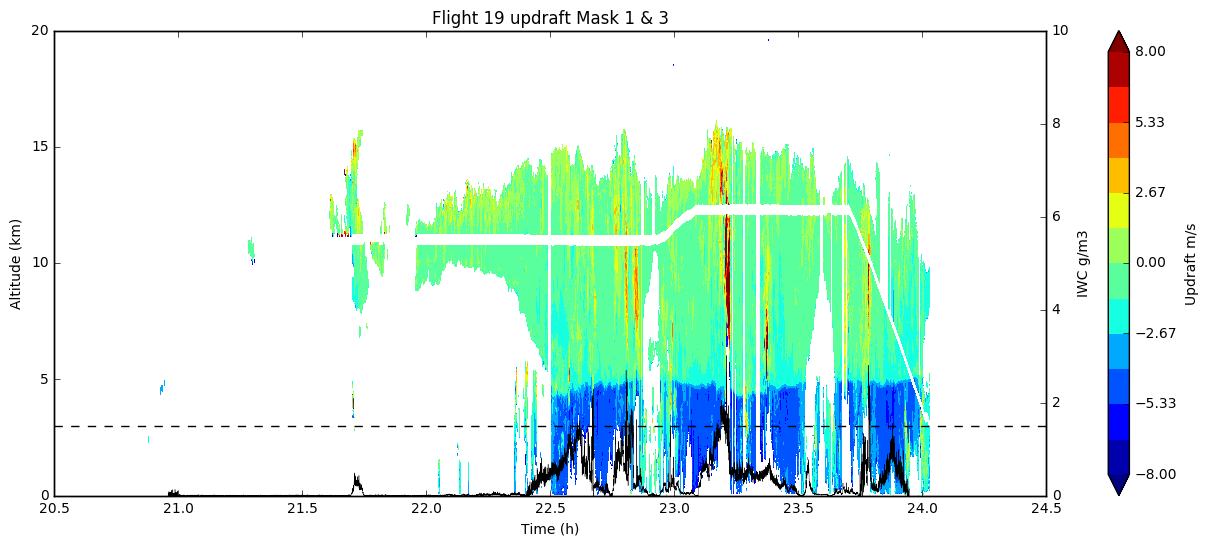

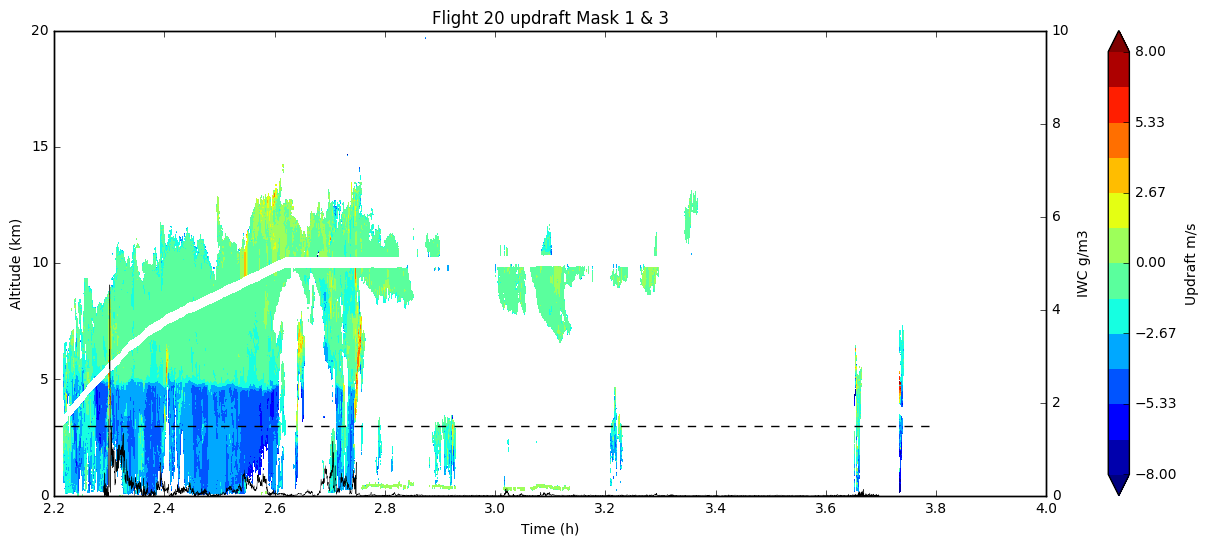

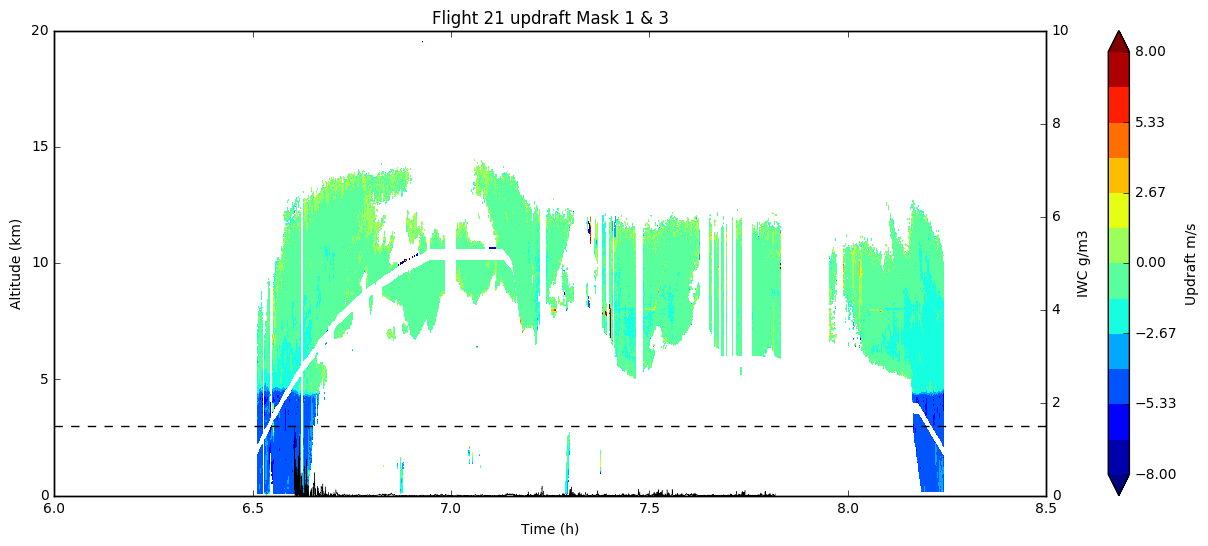

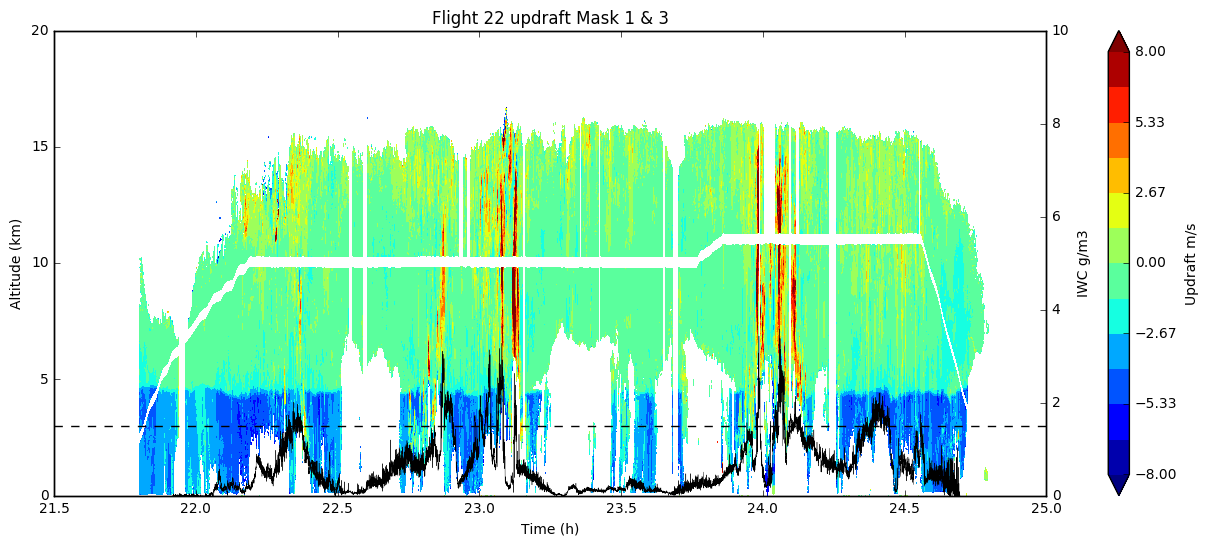

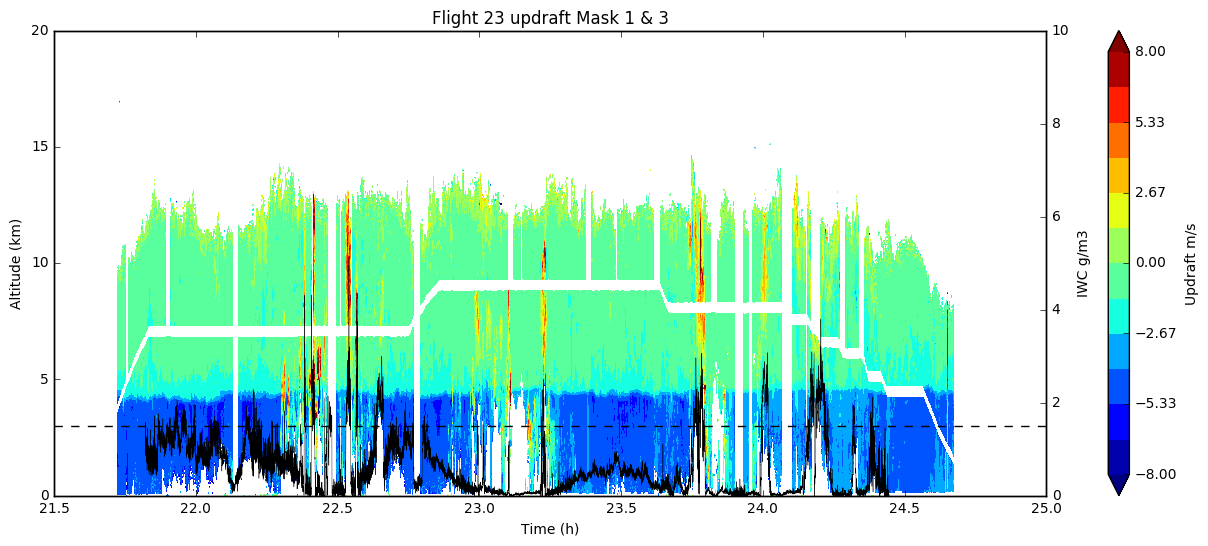

In [7]:
totaln=23
for i in range(totaln):
    try:
        szi=i+1
        fig=figure(figsize=[16,6])
        ds = loadRastaflt(szi)
#         tmp=ds.Vz.where((ds.Mask_Vz==1) | (ds.Mask_Vz==3))
        tmp=ds.Vz.where(ds.Mask_Vz==1)
        tmp=tmp.values.transpose()
        plt.contourf(np.tile(ds.time.values,(tmp.shape[0],1)),ds.height_2D.values.transpose(),
                     tmp,np.linspace(-8,8,13),extend='both')
        ax=plt.gca()
        hcb=plt.colorbar()
        hcb.set_label('Updraft m/s')
        plt.ylim(0,20)
        plt.xlabel('Time (h)')
        plt.ylabel('Altitude (km)')
        plt.title('Flight '+str(szi)+' updraft Mask 1 & 3')
        ax2=ax.twinx()
        indflt=(raw['flightnum']==szi)
        iwc=raw['TWCIKPZRgm3'][indflt]
        time=raw['Time'][indflt]
        ax2.plot(time/3600.,iwc,'k',linewidth=0.3)
        ax2.set_ylim(0,10)
        ax2.set_ylabel('IWC g/m3')
        ax2.plot(ax2.get_xlim(),np.array([1.5,1.5]),'k--')
        plt.show()
    except:
        pass

In [49]:
# w wind profile tripcolor plot
totaln=23
cbx=cby=cbz=np.array([])
for i in range(totaln):
# for i in range(12,13):
    try:
        szi=i+1
        
        ### For PSD data
        indflt=(raw['flightnum']==szi) & (iwc_mean>1.5)
        tmp = proc['indpsdforward'][indflt]
        tmp = tmp[~np.isnan(tmp)].astype(int)
        #### Need to convert to int otherwise float as index is not acceptable
        mmd = proc['MMD'][ tmp ]
        #### squeeze the dimension otherwise it will create a 3-D array.
        time = raw['Time'][ np.squeeze(proc['indpsdback'][tmp]) ]
        
        ### For RASTA data
        ds = loadRastaflt(szi).sel(method='nearest',time=np.squeeze(time/3600.),tolerance=1./3600)
#         tmp=ds.Vz.where((ds.Mask_Vz==1) | (ds.Mask_Vz==3))
        updf=ds.Vz.where(ds.Mask_Vz==1)
        
#         ### For some reason we don't need to provide norm=cnorm for it to normalize mmd
#         ### But once the colorv.to_rgba(mmd) is initilized by mmd, it no longer chanegs and doesn't
#         ### give the correct scale for mmd/2.
#         # Link http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter
#         # cnorm=mpl.colors.Normalize()
#         # cnorm.autoscale(mmd.ravel())
#         colorv=mpl.cm.ScalarMappable(norm=None, cmap=cmap)
#         colorv.to_rgba(mmd);
#         # colorv.to_rgba(mmd/2)
        
        x1=updf.transpose().values
        y1=ds.height_2D.transpose().values
        y1=y1-y1[249,:]
        z1=np.tile(squeeze(mmd),[x1.shape[0],1])
        x=x1.ravel()
        y=y1.ravel()
        z=z1.ravel()
        indvalid=(~np.isnan(x)) & ~np.isnan(y) & ~np.isnan(z)
        cbx=np.concatenate((cbx,x[indvalid]))
        cby=np.concatenate((cby,y[indvalid]))
        cbz=np.concatenate((cbz,z[indvalid]))
    except:
        pass

/net/san-a1-ib/data/keeling/a/szhu28/usr/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in greater


/net/san-a1-ib/data/keeling/a/szhu28/usr/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


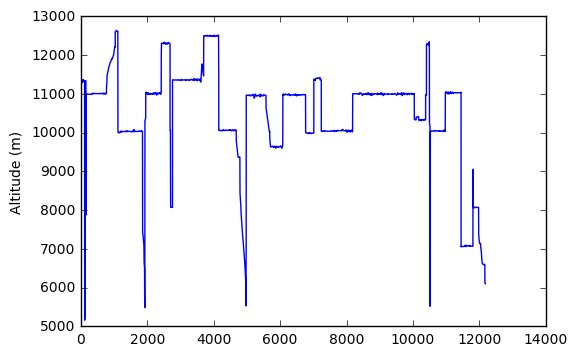

In [50]:
plot(raw['altGPS'][iwc_mean>1.5])
ylabel('Altitude (m)')

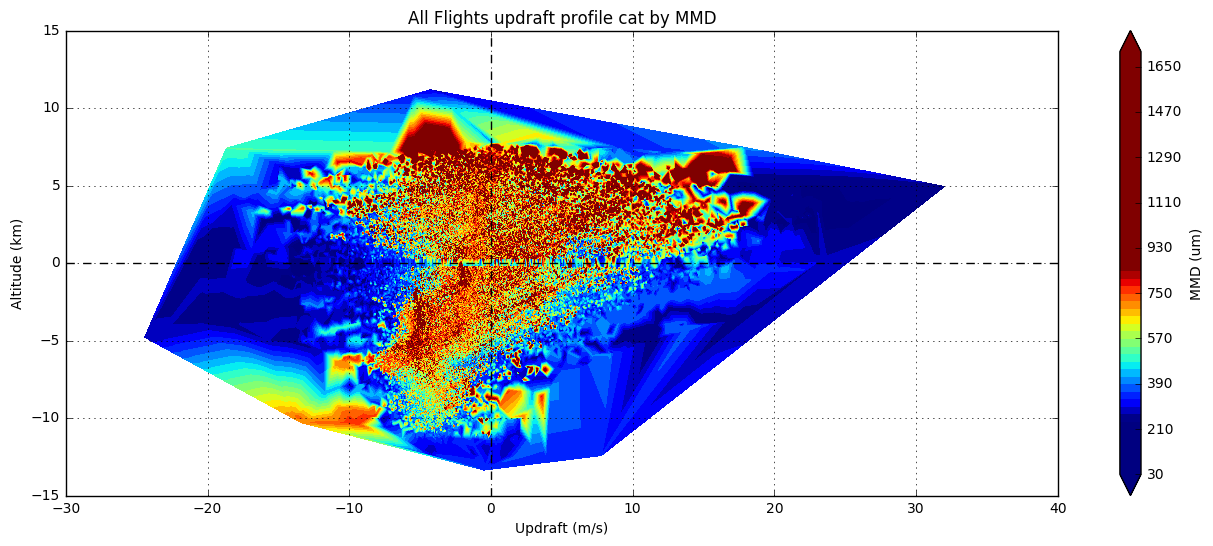

In [55]:
fig=figure(figsize=[16,6])
cmap=mpl.cm.get_cmap()
plt.tricontourf(cbx,cby,cbz,64,cmap=cmap,vmin=250,vmax=850,extend='both')
hcb=plt.colorbar()
hcb.set_label('MMD (um)')
ax=plt.gca()
plt.ylabel('Altitude (km)')
plt.xlabel('Updraft (m/s)')
plt.title('All Flights updraft profile cat by MMD')
plt.plot(plt.xlim(),np.array([0,0]),'k--')
plt.plot(np.array([0,0]),plt.ylim(),'k--')
plt.grid(b=True)
plt.show()

### Vertical wind profiles in different MMD categories

In [102]:
# grouped w wind profile by MMD cats
totaln=23
cbindbackward=cbmmd=np.zeros([0,1])
cbalt=cbupdf=np.ndarray([500,0])
for i in range(totaln):
# for i in range(12,13):
        szi=i+1
        
        ### For PSD data
        indflt=(raw['flightnum']==szi) & (iwc_mean>1.5)
        tmp = proc['indpsdforward'][indflt]
        tmp = tmp[~np.isnan(tmp)].astype(int)
        #### Need to convert to int otherwise float as index is not acceptable
        mmd = proc['MMD'][ tmp ]
        #### squeeze the dimension otherwise it will create a 3-D array.
        time = raw['Time'][ np.squeeze(proc['indpsdback'][tmp]) ]
        
        ### For RASTA data
        try:
            ds = loadRastaflt(szi).sel(method='nearest',time=np.squeeze(time/3600.),tolerance=1./3600)
        except:
            continue
            pass
#         updf=ds.Vz.where((ds.Mask_Vz==1) | (ds.Mask_Vz==3))
        if np.prod(ds.Vz.shape) == 0:
            continue;
        updf = ds.Vz.where(ds.Mask_Vz==1).values.transpose()
        alt = ds.height_2D.values.transpose()
        if updf.ndim == 1:
            updf=updf[:,np.newaxis]
            alt=alt[:,np.newaxis]
            time=time[np.newaxis,:]
            
        alt = alt-alt[249,:]
        
        cbindbackward=np.concatenate( (cbindbackward,time),axis=0 )
        cbmmd=np.concatenate( (cbmmd,mmd),axis=0 )
        cbupdf=np.concatenate( (cbupdf,updf),axis=1 )
        cbalt=np.concatenate( (cbalt,alt),axis=1 )
#     except:
#         pass
        

/net/san-a1-ib/data/keeling/a/szhu28/usr/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in greater


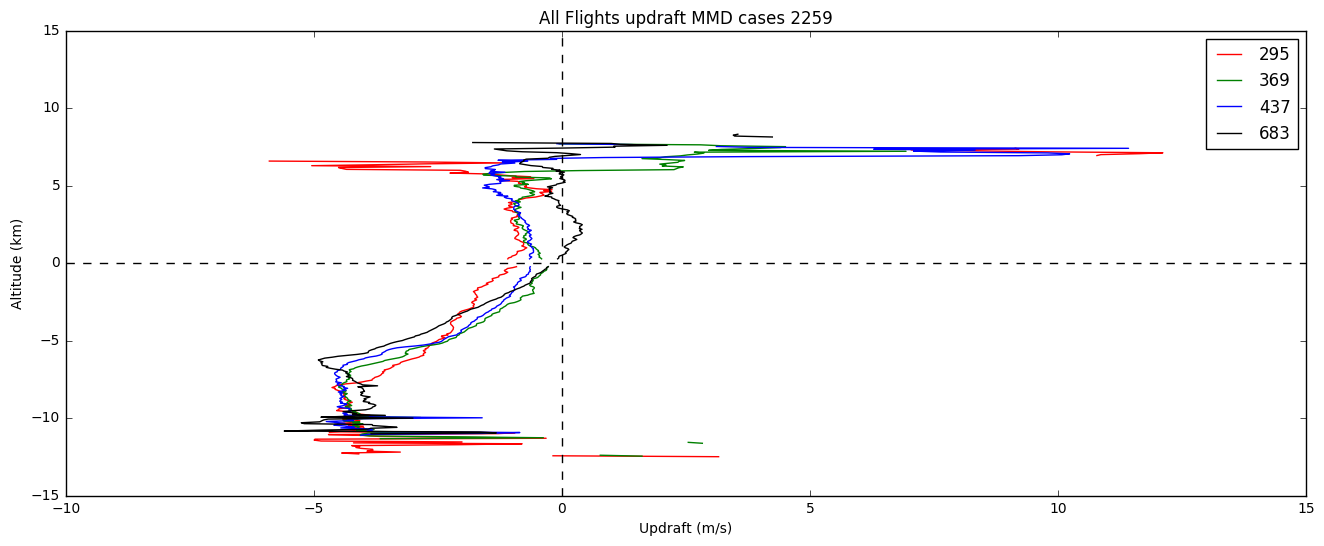

In [106]:
fig=figure(figsize=[16,6])
mmdbins = np.percentile(cbmmd, np.arange(0,100.1,25))
mmdind = np.digitize(cbmmd,mmdbins)

tmpc=np.array(['r','g','b','k'])
tmpmmd=np.zeros(len(mmdbins)-1)
for j in range(1,len(mmdbins)):
    tmpind=np.in1d(mmdind,j)
    x1=cbupdf[:,tmpind]
    y1=cbalt[:,tmpind]
    x0=np.nanmean(x1,axis=1)
    y0=np.nanmean(y1,axis=1)
    tmpmmd[j-1]=np.nanmean(cbmmd[tmpind])
#             plot(x0,y0,c=colormapping.to_rgba(tmpmmd[j-1]))
    plot(x0,y0,c=tmpc[j-1])

ax=plt.gca()
ax.legend(tmpmmd.astype(int).astype(str),loc='best')
plt.ylabel('Altitude (km)')
plt.xlabel('Updraft (m/s)')
plt.title('All Flights updraft MMD cases '+str(len(np.squeeze(cbmmd))))
plt.plot(plt.xlim(),np.array([0,0]),'k--')
plt.plot(np.array([0,0]),plt.ylim(),'k--')
plt.show()

In [56]:
sum(indflt)

0

In [47]:
### Vertical wind profiles in different IWC categories

# grouped w wind profile by MMD cats
import numpy.core.defchararray as npch

mmdbins = np.array([0,300,400,500,600,700,800,1000,2000])
mmdind = np.digitize(mmd,mmdbins)
colormapping=mpl.cm.ScalarMappable(norm=None, cmap='jet')
colors=colormapping.to_rgba( np.arange(len(mmdbins)-1) )

totaln=23
for i in range(totaln):
# for i in range(12,13):
#     try:
        szi=i+1
        fig=figure(figsize=[16,6])
        
        ### For PSD data
        indflt=(raw['flightnum']==szi) & (iwc_mean>1.5)
        tmp = proc['indpsdforward'][indflt]
        tmp = tmp[~np.isnan(tmp)].astype(int)
        #### Need to convert to int otherwise float as index is not acceptable
        mmd = proc['MMD'][ tmp ]
        #### squeeze the dimension otherwise it will create a 3-D array.
        time = raw['Time'][ np.squeeze(proc['indpsdback'][tmp]) ]
        
        ### For RASTA data
        ds = loadRastaflt(szi).sel(method='nearest',time=np.squeeze(time/3600.),tolerance=1./3600)
        tmp=ds.height_2D.values
#         updf=ds.Vz.where((ds.Mask_Vz==1) | (ds.Mask_Vz==3))
        updf = ds.Vz.where(ds.Mask_Vz==1)
        
#         mmdbins = np.percentile(mmd, np.arange(0,100.1,25))
        
        for j in range(1,len(mmdbins)):
            tmpind=np.in1d(mmdind,j)
            if np.sum(tmpind) ==0:
                plot([],[],c=colors[j-1])
                continue
            x1=updf.values[tmpind,:].transpose()
            y1=(tmp[tmpind,:]-tmp[tmpind,249][:,np.newaxis]).transpose()
            x0=np.nanmean(x1,axis=1)
            y0=np.nanmean(y1,axis=1)
#             plot(x0,y0,c=colormapping.to_rgba(tmpmmd[j-1]))
            plot(x0,y0,c=colors[j-1])
            
        ax=plt.gca()
        ax.legend( npch.add(npch.add( mmdbins[:-1].astype(str),' - '),mmdbins[1:].astype(str) ),loc='best')
        plt.ylabel('Altitude (km)')
        plt.xlabel('Updraft (m/s)')
        plt.title('Flight '+str(szi)+' updraft MMD cases '+str(len(np.squeeze(mmd))))
        plt.plot(plt.xlim(),np.array([0,0]),'k--')
        plt.plot(np.array([0,0]),plt.ylim(),'k--')
        plt.show()
#     except:
#         pass

/net/san-a1-ib/data/keeling/a/szhu28/usr/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in greater


IndexError: The indexing operation you are attempting to perform is not valid on netCDF4.Variable object. Try loading your data into memory first by calling .load().

Original traceback:
Traceback (most recent call last):
  File "/data/keeling/a/szhu28/usr/anaconda2/lib/python2.7/site-packages/xarray/backends/netCDF4_.py", line 53, in __getitem__
    data = getitem(self.array, key)
  File "netCDF4/_netCDF4.pyx", line 3672, in netCDF4._netCDF4.Variable.__getitem__ (netCDF4/_netCDF4.c:37232)
  File "/data/keeling/a/szhu28/usr/anaconda2/lib/python2.7/site-packages/netCDF4/utils.py", line 391, in _out_array_shape
    c = count[..., i].ravel()[0] # All elements should be identical.
IndexError: index 0 is out of bounds for axis 0 with size 0


/net/san-a1-ib/data/keeling/a/szhu28/usr/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in greater


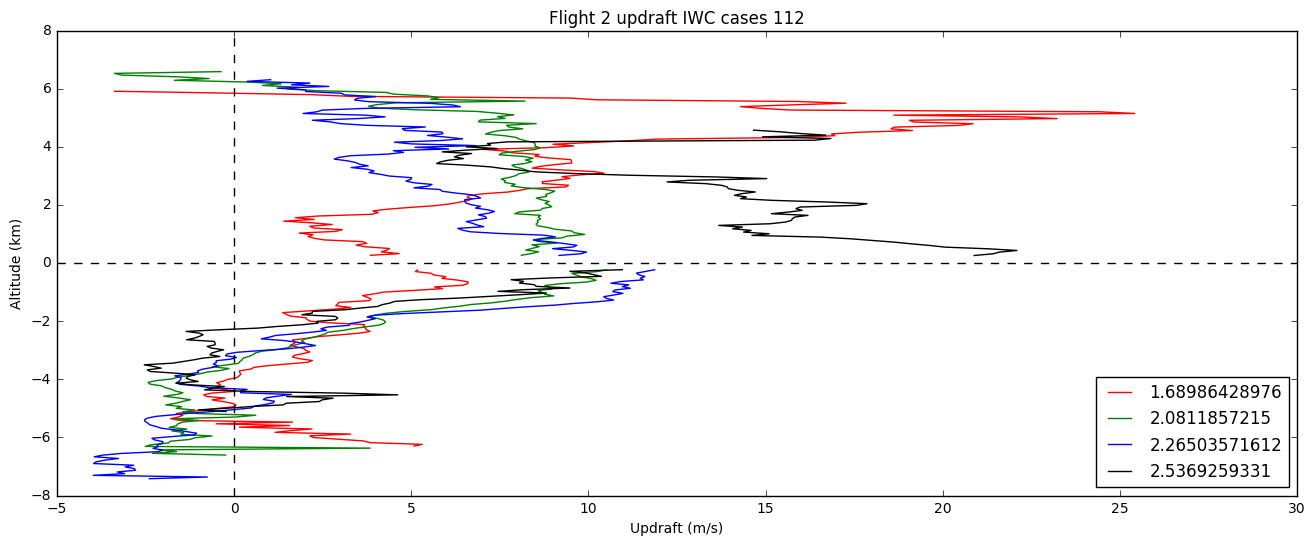

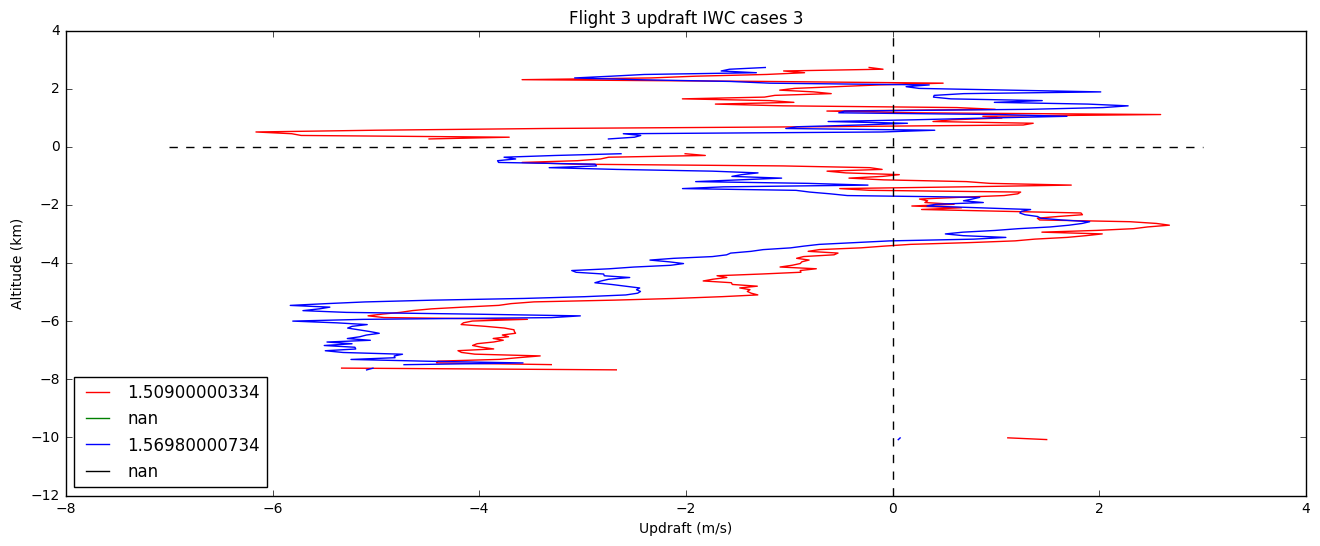

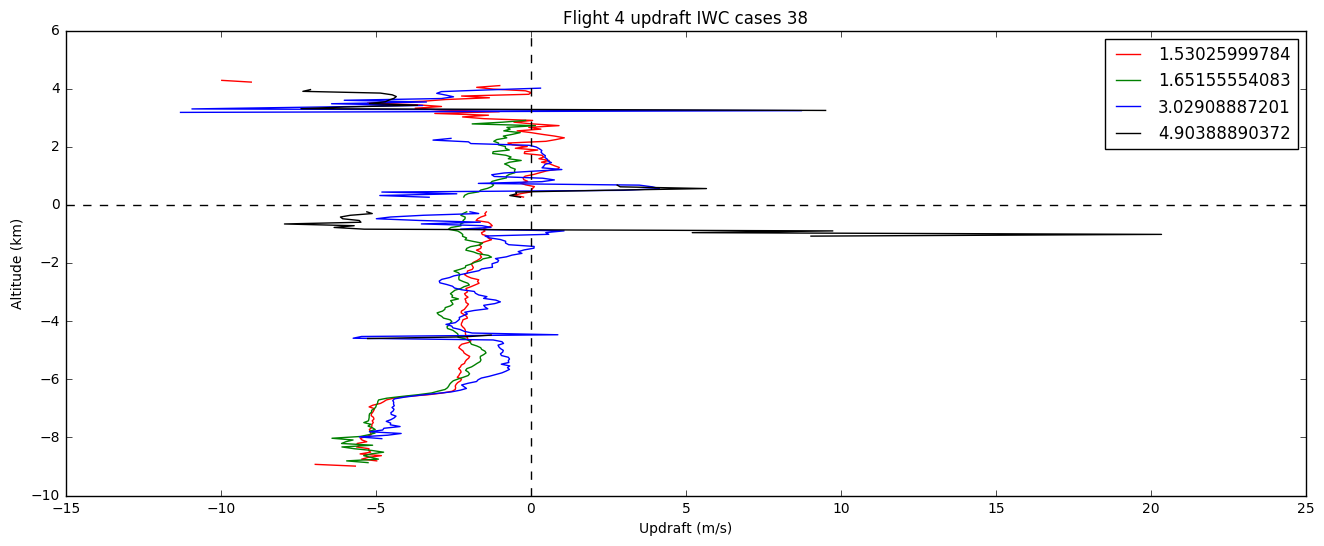

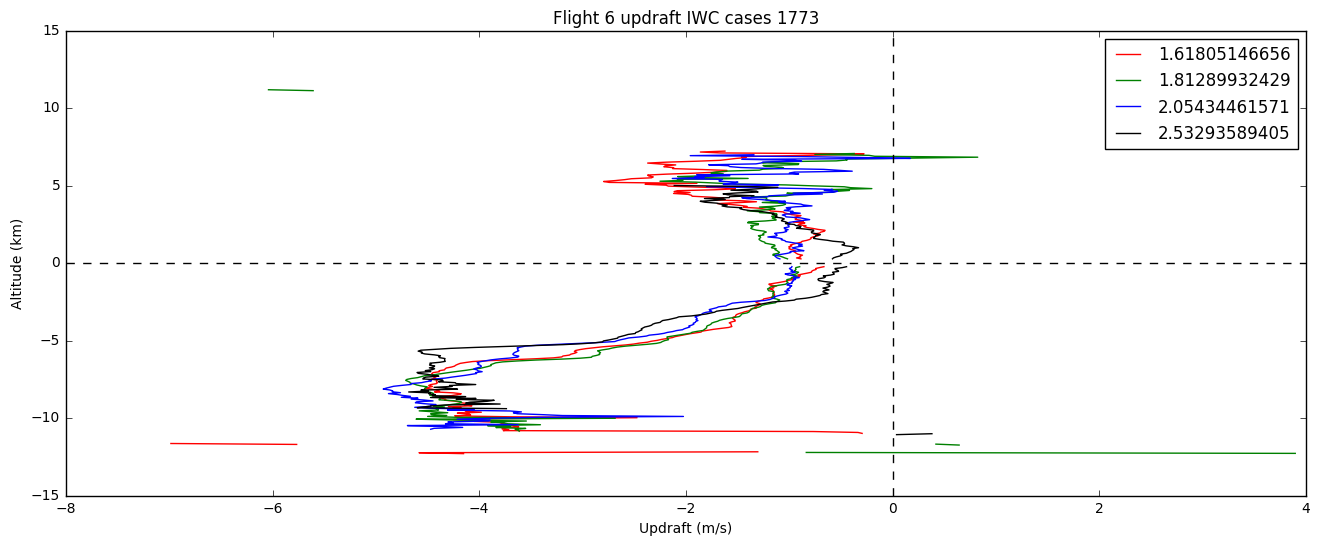

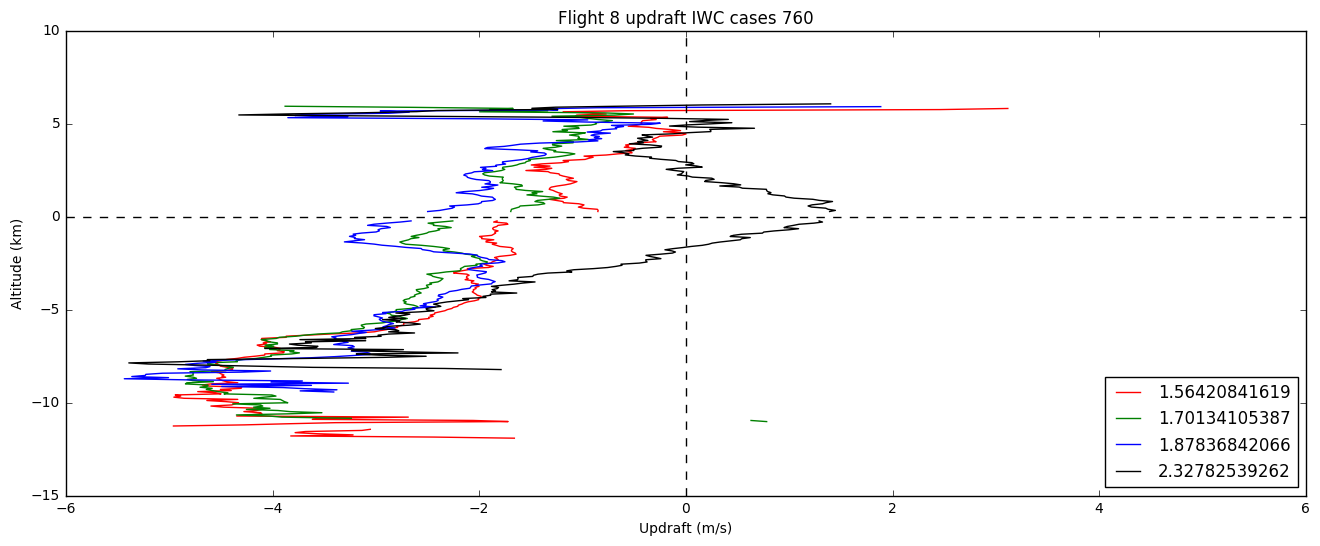

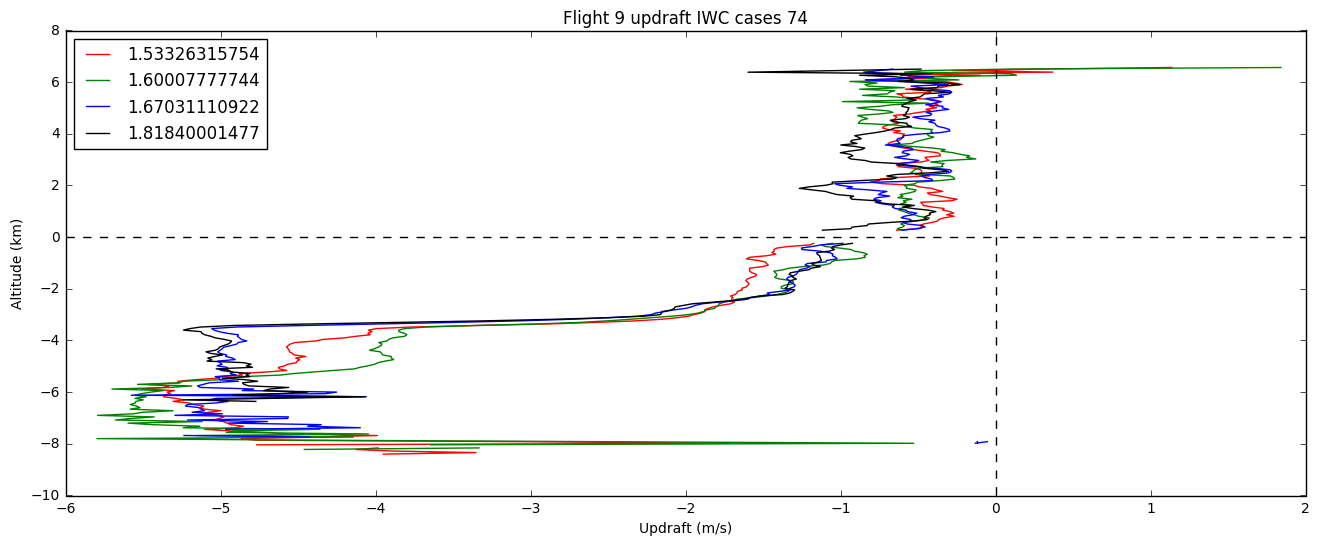

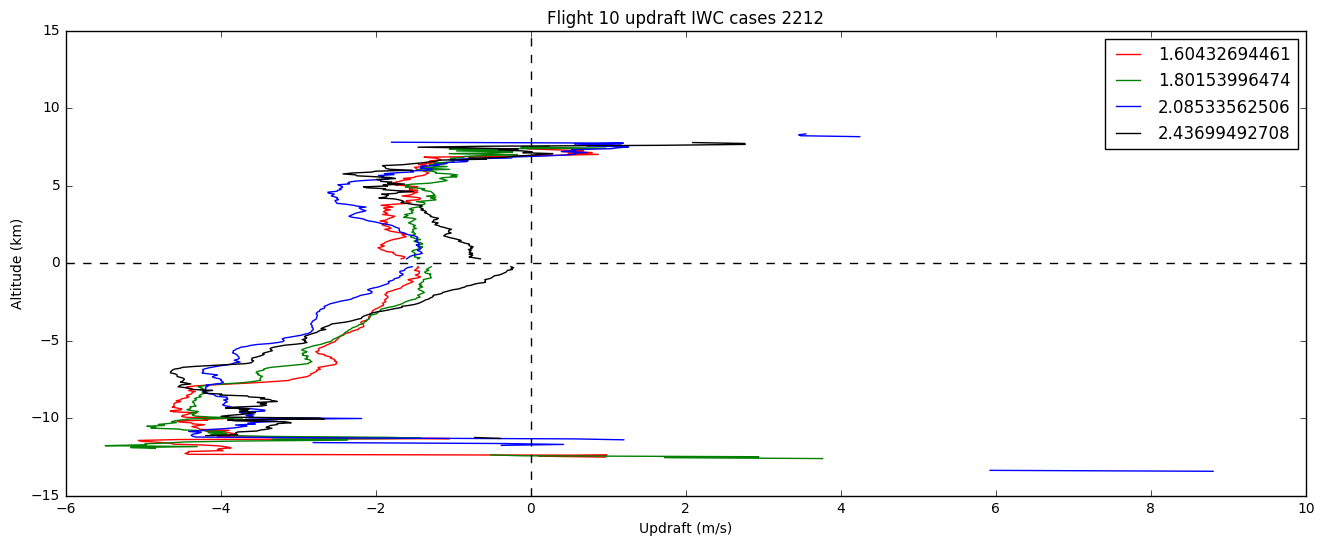

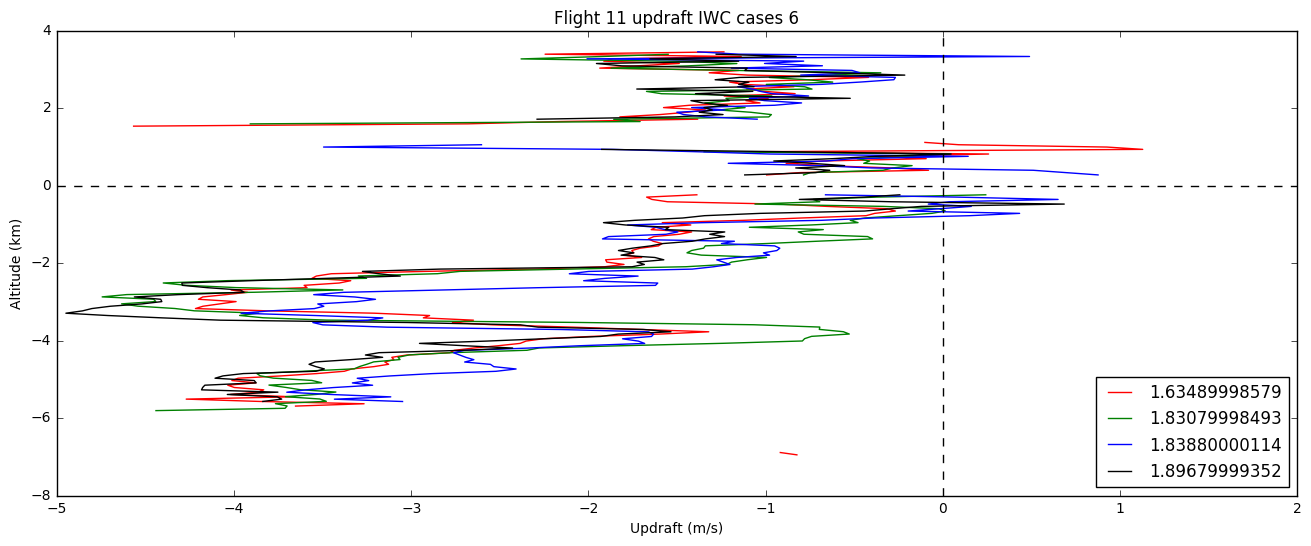

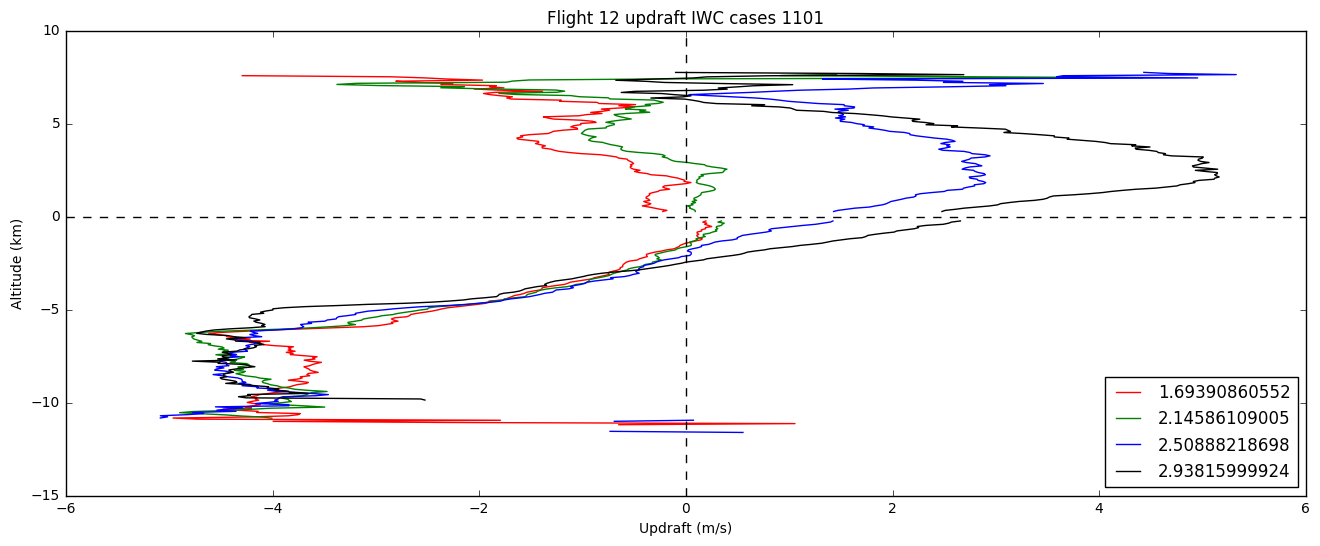

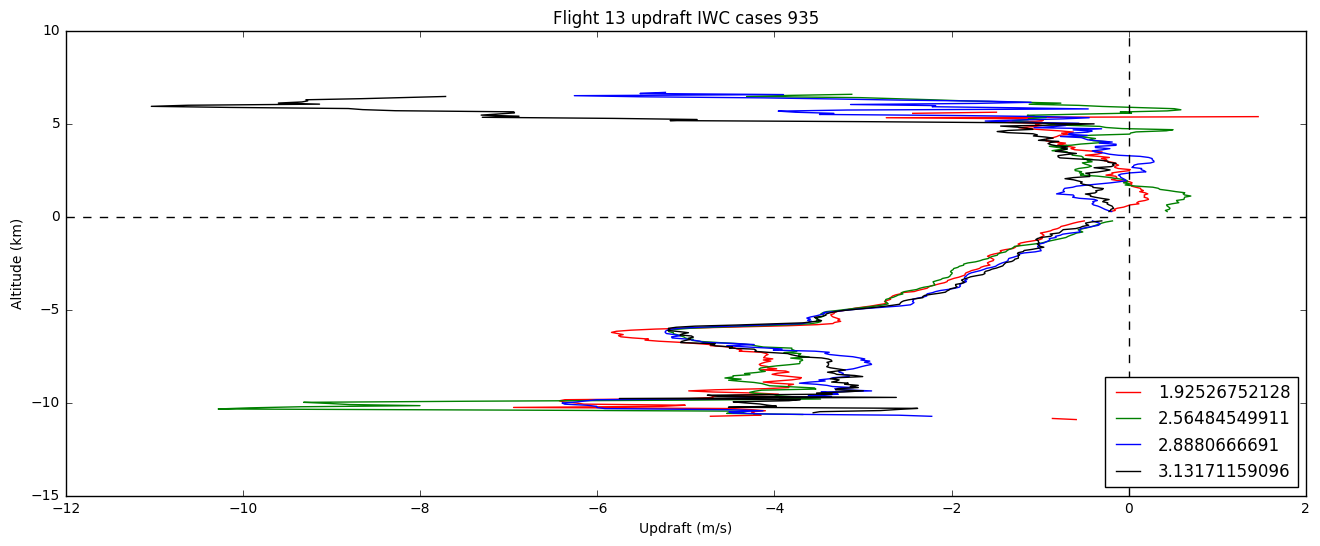

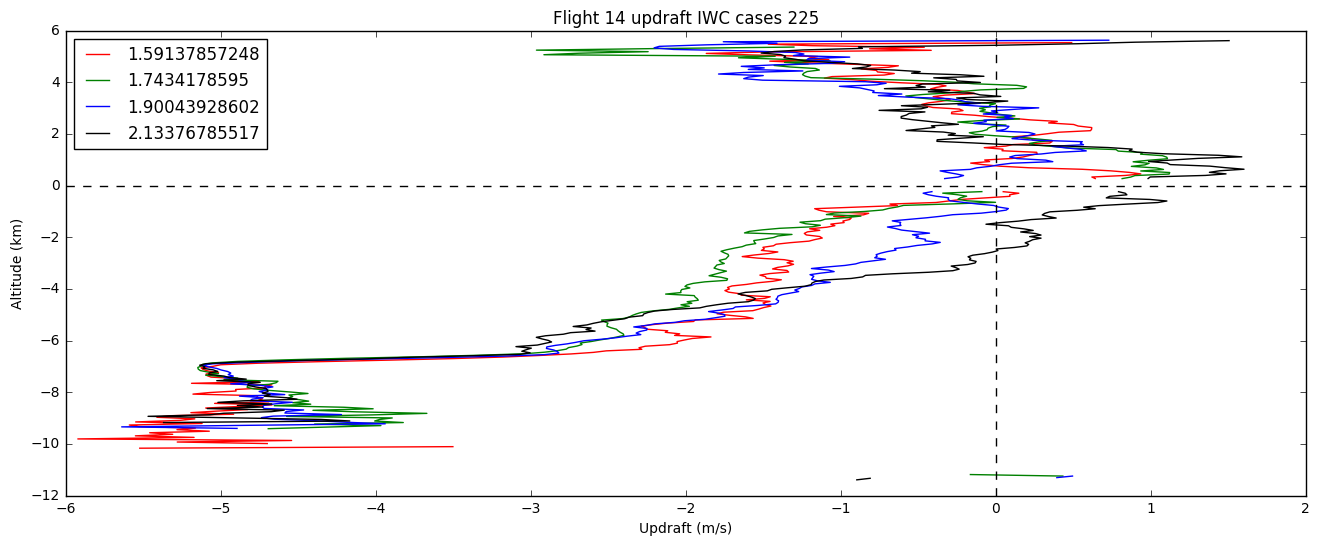

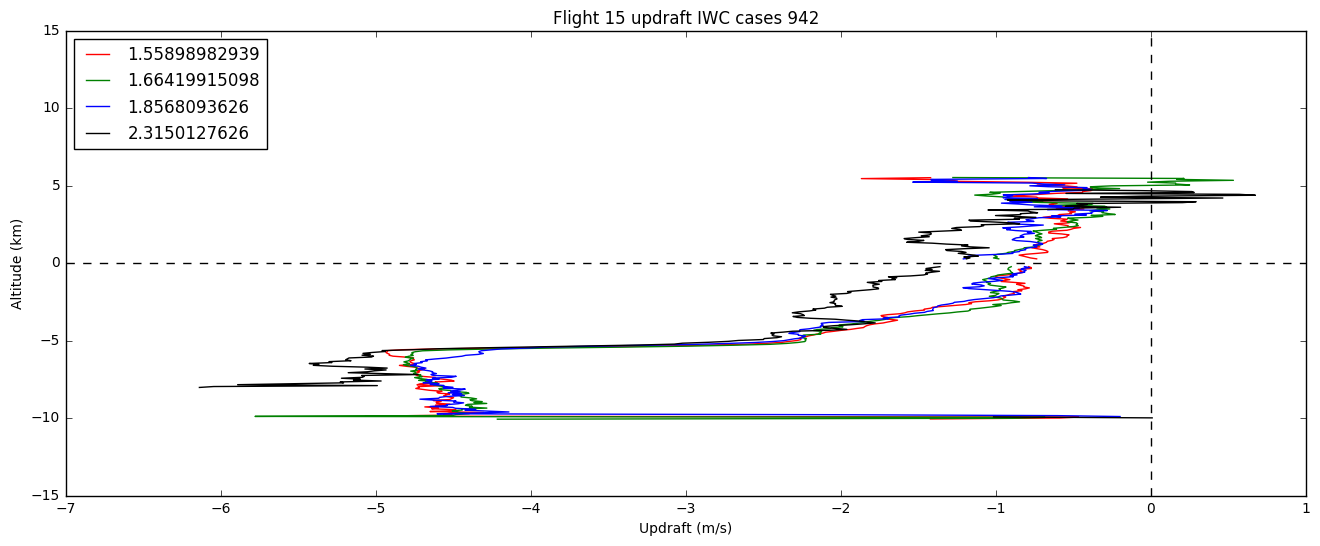

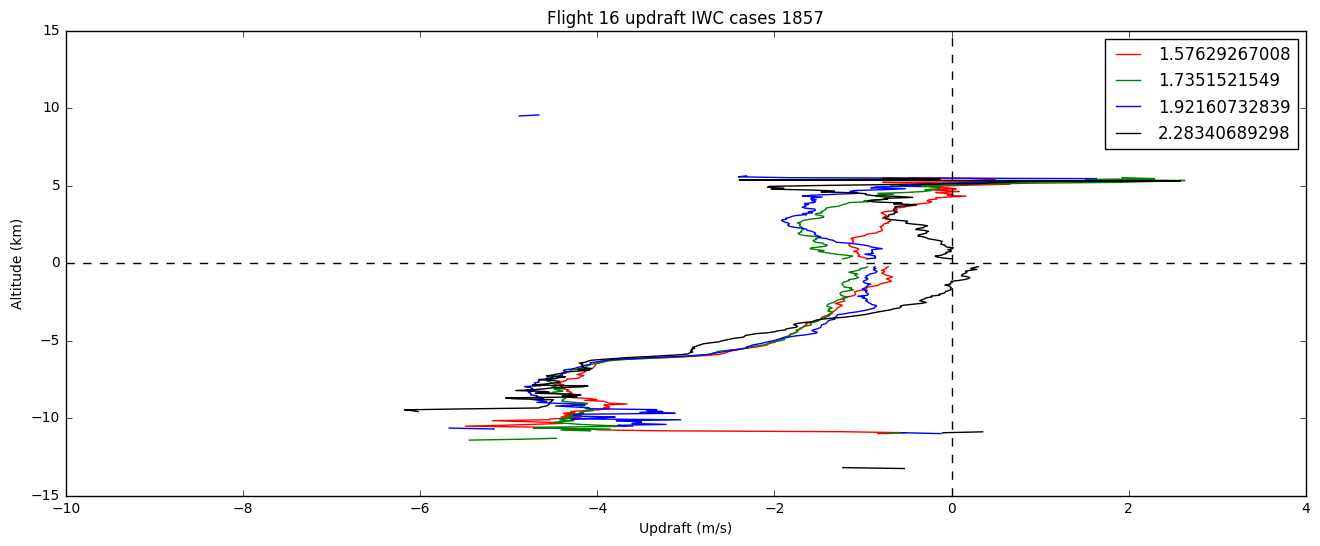

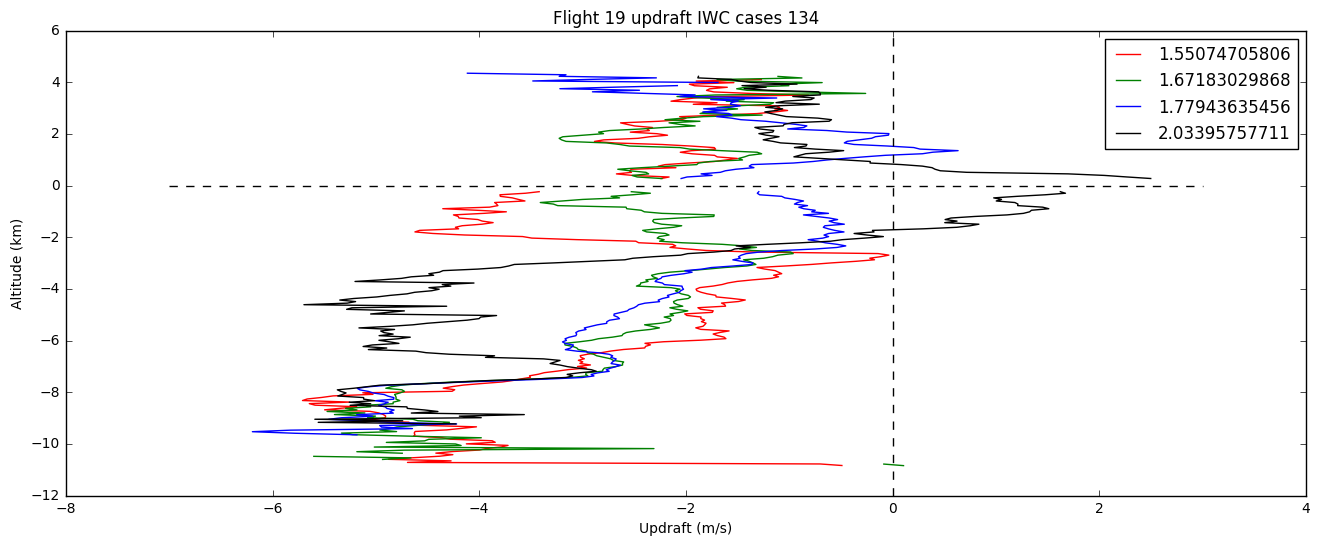

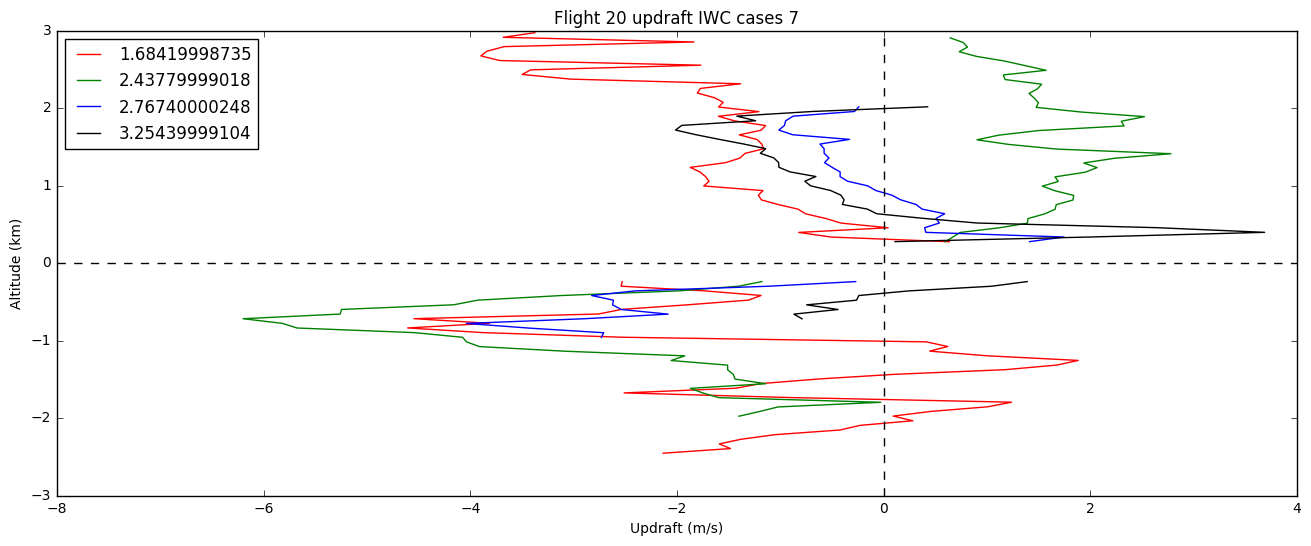

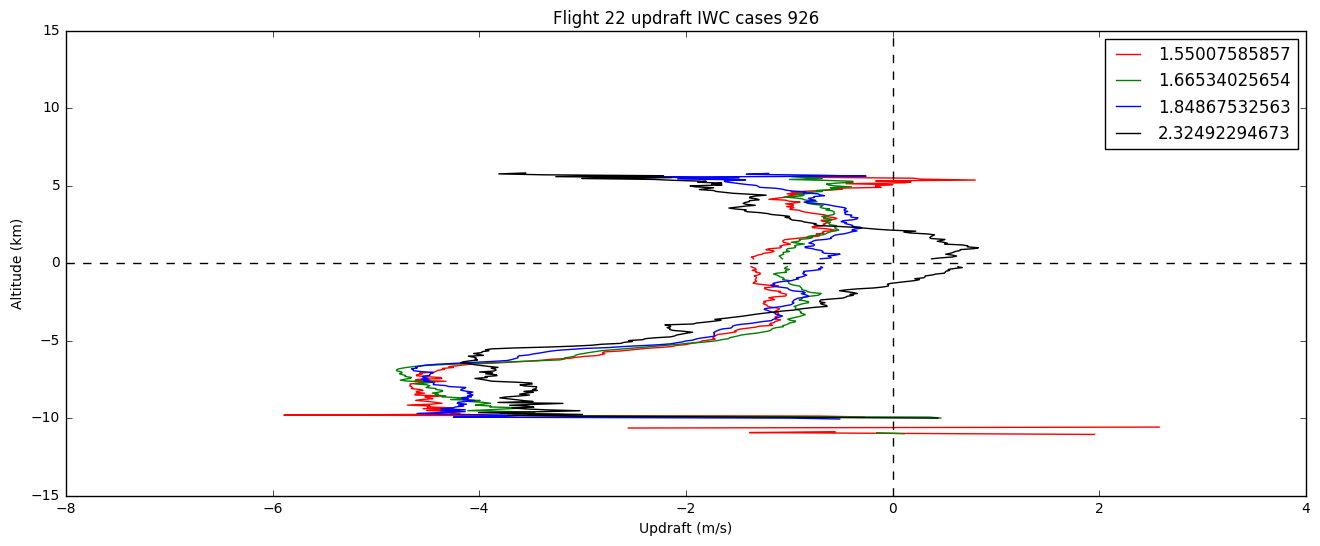

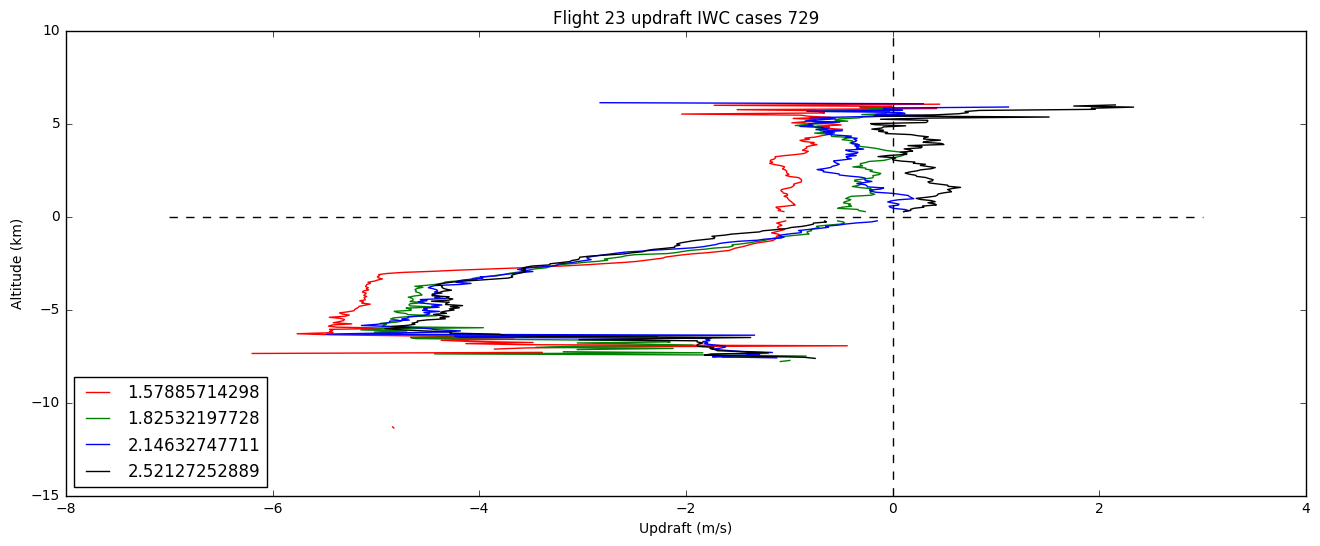

In [21]:
# grouped w wind profile by IWC cats
import pandas as pd


totaln=23
for i in range(totaln):
# for i in range(12,13):
    try:
        szi=i+1
        fig=figure(figsize=[16,6])
        
        ### For PSD data
        indflt=((raw['flightnum']==szi) & (iwc_mean>1.5))
        #### Need to convert to int otherwise float as index is not acceptable
        mmd = iwc_mean[ indflt ]
        #### squeeze the dimension otherwise it will create a 3-D array.
        time = raw['Time'][ indflt ]
        
        ### For RASTA data
        ds = loadRastaflt(szi).sel(method='nearest',time=np.squeeze(time/3600.),tolerance=1./3600)
#         updf=ds.Vz.where((ds.Mask_Vz==1) | (ds.Mask_Vz==3))
        updf = ds.Vz.where(ds.Mask_Vz==1)
        
        mmdbins = np.percentile(mmd, np.arange(0,100.1,25))
        mmdind = np.digitize(mmd,mmdbins)
        colormapping=mpl.cm.ScalarMappable(norm=None, cmap='jet')
        colors=colormapping.to_rgba(mmdbins[:-1]+np.diff(mmdbins))
        
        tmpc=np.array(['r','g','b','k'])
        tmpmmd=np.zeros(len(mmdbins)-1)
        for j in range(1,len(mmdbins)):
            tmpind=np.in1d(mmdind,j)
            x1=updf.values[tmpind,:].transpose()
            tmp=ds.height_2D.values
            y1=(tmp[tmpind,:]-tmp[tmpind,249][:,np.newaxis]).transpose()
            x0=np.nanmean(x1,axis=1)
            y0=np.nanmean(y1,axis=1)
            tmpmmd[j-1]=np.nanmean(mmd[tmpind])
#             plot(x0,y0,c=colormapping.to_rgba(tmpmmd[j-1]))
            plot(x0,y0,c=tmpc[j-1])
            
        ax=plt.gca()
        ax.legend(tmpmmd.astype(str),loc='best')
        plt.ylabel('Altitude (km)')
        plt.xlabel('Updraft (m/s)')
        plt.title('Flight '+str(szi)+' updraft IWC cases '+str(len(np.squeeze(mmd))))
        plt.plot(plt.xlim(),np.array([0,0]),'k--')
        plt.plot(np.array([0,0]),plt.ylim(),'k--')
        plt.show()
    except:
        pass

### Is SAFFIRE V5 data also indicating typical downdraft at the flight level?

In [7]:
mmd.shape

(22, 1)

/net/san-a1-ib/data/keeling/a/szhu28/usr/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in greater


0 mmd valid in flt 1


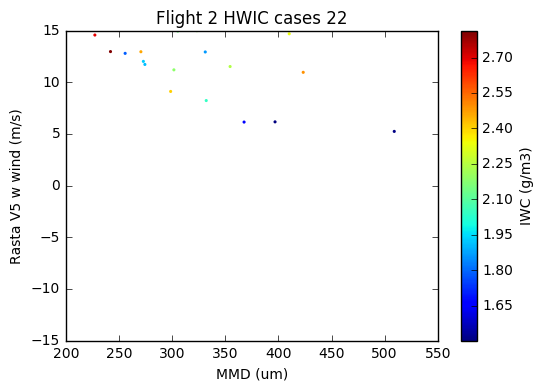

0 mmd valid in flt 3


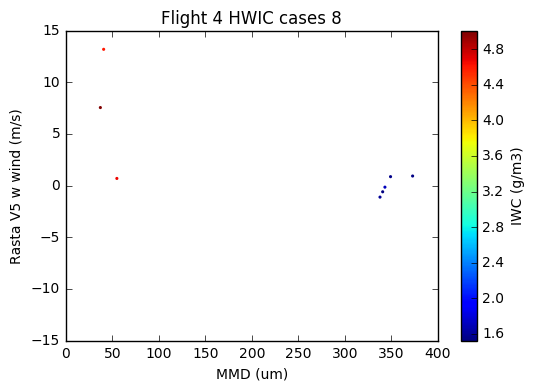

error in flt 5


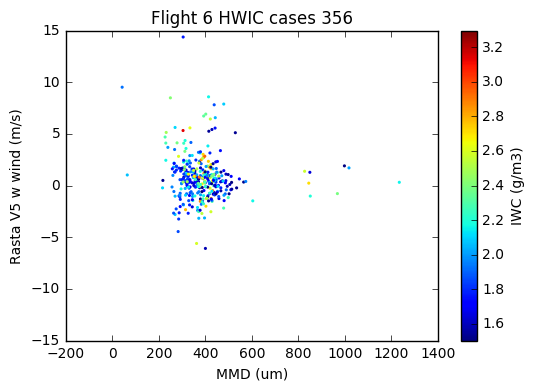

0 mmd valid in flt 7


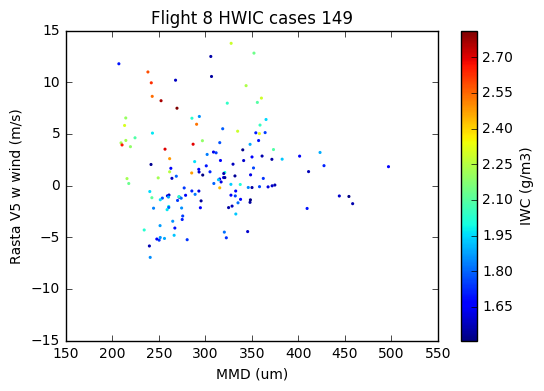

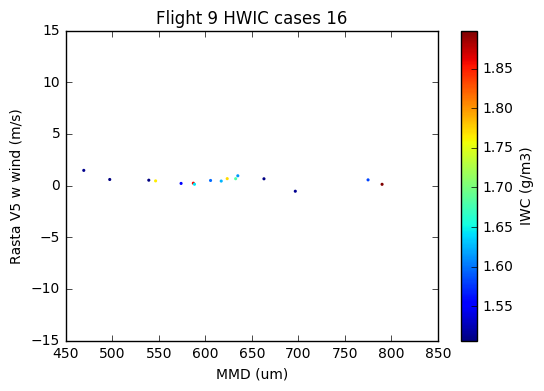

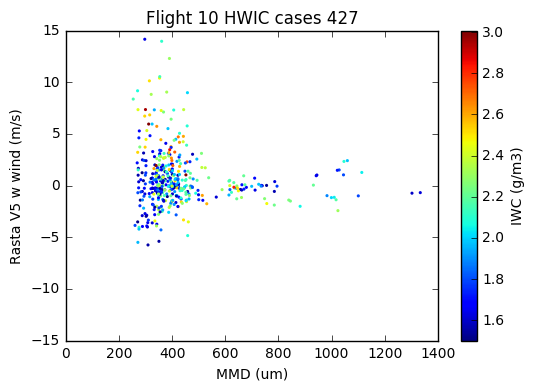

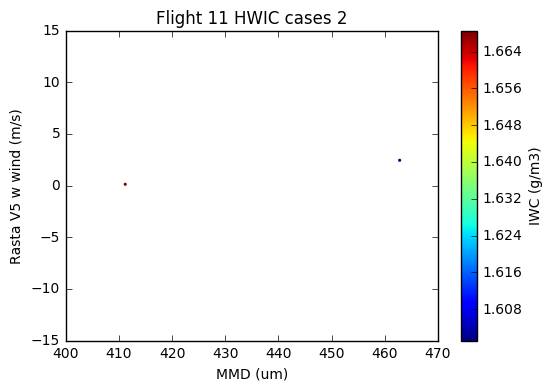

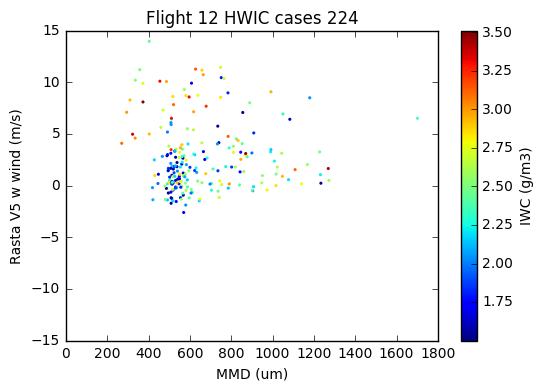

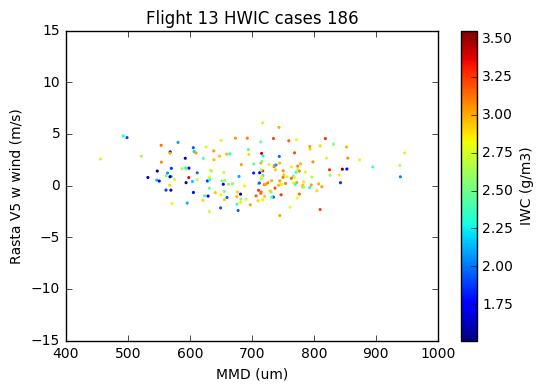

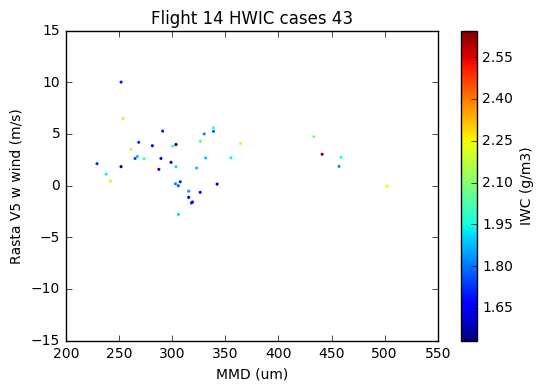

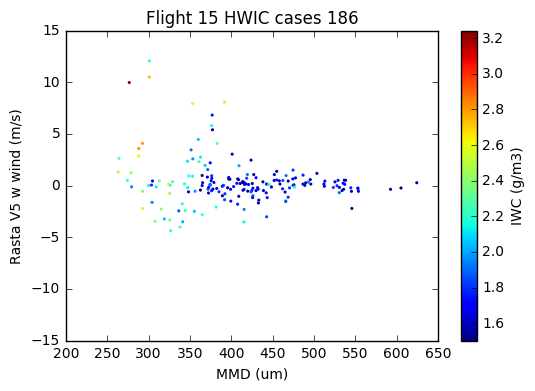

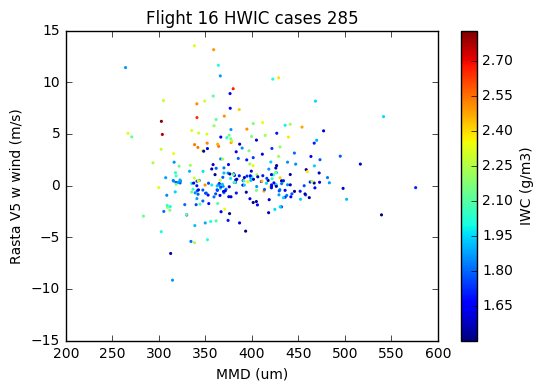

0 mmd valid in flt 17
error in flt 18


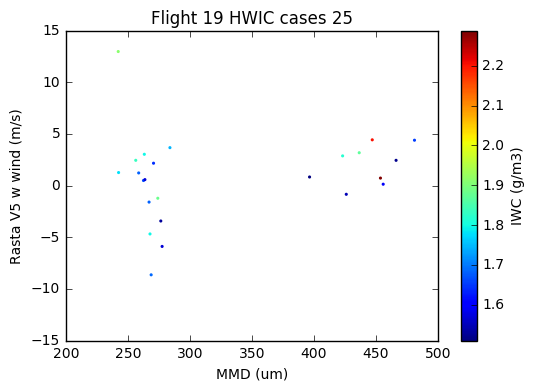

0 mmd valid in flt 21


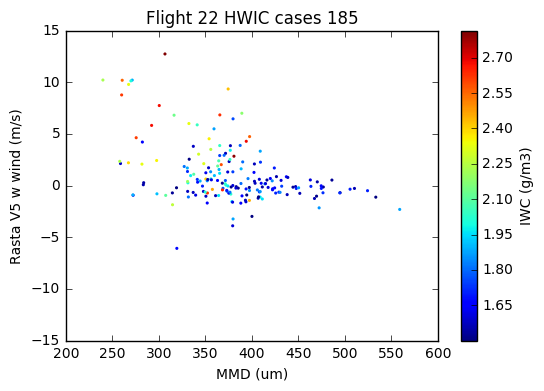

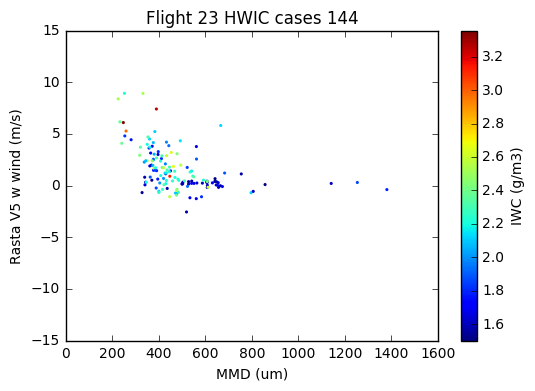

In [19]:
totaln=23
for i in range(totaln):
    szi=i+1
    indflt = (iwc_mean>1.5) & (raw['flightnum']==i+1) & (~np.isnan(proc['indpsdforward']))
    time=raw['Time'][indflt]
    try:
        ds = loadRastaflt(szi).w_wind.sel(method='nearest',time=np.squeeze(time/3600.),tolerance=1./3600)
    except:
        pass
    tmp=ds.values
    try:
        if tmp.shape[0]==time.shape[0]:
            pass
        else:
            print('error in flt '+str(szi))
            continue
    except:
        pass
        continue
    
    wwind = tmp
    
    tmp = proc['indpsdforward'][indflt]
    tmp = tmp[~np.isnan(tmp)].astype(int)
    #### Need to convert to int otherwise float as index is not acceptable
    mmd = proc['MMD'][ tmp ]
    iwc = iwc_mean[ proc['indpsdback'][tmp] ]
    if np.prod(mmd.shape)==0:
        print('0 mmd valid in flt '+str(szi))
        continue
        
    scatter(mmd,wwind,c=iwc,s=5,lw=0)
    hcb=plt.colorbar()
    hcb.set_label('IWC (g/m3)')
    plt.ylabel('Rasta V5 w wind (m/s)')
    plt.xlabel('MMD (um)')
    ax=plt.gca()
#     ax.set_xlim(1,5)
    ax.set_ylim(-15,15)
    plt.title('Flight '+str(szi)+' HWIC cases '+str(len(np.squeeze(mmd))))
    plt.show()

In [11]:
tmp

array(7.989976406097412)